In [1]:
# coding: utf8
import tensorflow as tf
import matplotlib as mp
from konlpy.tag import Hannanum

In [2]:
GO = '<GO>'
EOD = '<EOD>'
PAD = '<PAD>'

In [3]:

import spacy
nlp = spacy.load("en_core_web_lg")


In [115]:
data = "./../kor-eng/kor.txt"
texts = open(data, mode='rt', encoding='utf-8-sig').read().split("\n")

pair_kor=[]
pair_eng=[]
KMA = Hannanum()

for text in texts:
    pair = text.split("\t")
    if len(pair)==2:
        kor = KMA.pos(pair[1])
        tmp = []
        for p in kor:            
            tmp.append (p[0]+"/"+p[1])
        pair_kor.append(tmp+[EOD])
        pair_eng.append(KMA.morphs(pair[0])+[EOD])
    else:
        continue
    
    
    
assert len(pair_kor)==len(pair_eng)
print(pair_kor[0])
print(pair_eng[0])

['누구/N', '?/S', '<EOD>']
['Who', '?', '<EOD>']


In [116]:
import pickle
with open("./translation_preprocessed.p", 'wb') as out_file:
    pickle.dump( (pair_eng, pair_kor), out_file)


In [4]:
import pickle
def load_preprocess():
    preprocess_file = "./translation_preprocessed.p"
    print(preprocess_file)
    with open(preprocess_file, mode='rb') as in_file:
        return pickle.load(in_file)
    
(pair_eng, pair_kor) = load_preprocess()
assert (len(pair_eng) == len(pair_kor))

./translation_preprocessed.p


In [5]:
voca_eng = set()
for sent in pair_eng:
    for w in sent:
        voca_eng.add(w)

voca_kor = set()        
for sent in pair_kor:
    for w in sent:
        voca_kor.add(w)

In [6]:
print([v for i, v in enumerate(voca_kor)][:10])
print([v for i, v in enumerate(voca_eng)][:10])

['읽/P', '즐겁/P', '3년/N', '여름/N', '이유/N', '누군가/N', '머리카락/N', '켜/P', '침대/N', '가끔/M']
['months', 'translating', 'winter', 'into', 'Make', 'serve', 'slammed', 'what', 'us', 'jeans']


In [7]:
voca_k_to_int = {c: i+2 for i, c in enumerate(voca_kor)}
voca_e_to_int = {c: i+2 for i, c in enumerate(voca_eng)}


voca_k_to_int[GO] = 1
voca_k_to_int[PAD] = 0

voca_e_to_int[PAD] = 0
voca_e_to_int[GO] = 0

int_to_voca_k = {}
int_to_voca_e = {}

for v in voca_k_to_int:
    i = voca_k_to_int[v]
    int_to_voca_k[i] = v
    
for v in voca_e_to_int:
    i = voca_e_to_int[v]
    int_to_voca_e[i] = v    
    
print(voca_k_to_int[PAD], voca_k_to_int[GO], voca_k_to_int[EOD])
print(voca_e_to_int[PAD], voca_e_to_int[EOD])

0 1 248
0 241


In [8]:
source_sent_ids = [[voca_e_to_int[v] for v in sent] for sent in pair_eng]
target_sent_ids = [[voca_k_to_int[v] for v in sent] for sent in pair_kor]

In [9]:
print(pair_eng[0:3], source_sent_ids[0:3])
print(pair_kor[0:3], target_sent_ids[0:3])

[['Who', '?', '<EOD>'], ['Hello', '!', '<EOD>'], ['No', 'way', '!', '<EOD>']] [[321, 32, 241], [995, 784, 241], [105, 383, 784, 241]]
[['누구/N', '?/S', '<EOD>'], ['안녕/I', '!/S', '<EOD>'], ['절대/M', '아니/P', '야/E', './S', '<EOD>']] [[808, 1188, 248], [1144, 226, 248], [318, 1318, 426, 1309, 248]]


In [10]:
# Number of Epochs
epochs = 200
# Batch Size
batch_size = 4
# RNN Size
rnn_size = 512
rnn_size_dec=rnn_size

# Number of Layers
num_layers = 2
# Embedding Size
encoding_embedding_size = 128
decoding_embedding_size = 128
# Learning Rate
learning_rate = 0.001
keep_prob=0.6
beam_width=3

In [11]:
tf.reset_default_graph()
def get_model_inputs():
    input_data = tf.placeholder(tf.int32, [None, None], name='input')
    targets = tf.placeholder(tf.int32, [None, None], name='targets')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    
    target_sequence_length = tf.placeholder(tf.int32, (None,), name='target_sequence_length')
    max_target_sequence_length = tf.reduce_max(target_sequence_length, name='max_target_len')
    source_sequence_length = tf.placeholder(tf.int32, (None,), name='source_sequence_length')
    
    return input_data, targets, lr, target_sequence_length, max_target_sequence_length, source_sequence_length

In [12]:
from tensorflow.contrib import rnn
from tensorflow.contrib.rnn import LSTMStateTuple

def encoding_layer(input_data, rnn_size, num_layers, source_sequence_length, source_vocab_size):
    
    enc_embed_input = tf.contrib.layers.embed_sequence(input_data, source_vocab_size,
                                                       encoding_embedding_size)
    def make_cell(rnn_size):
        enc_cell = tf.contrib.rnn.LSTMCell(rnn_size,
                                          initializer=tf.contrib.layers.xavier_initializer())#initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
        return enc_cell
    
    fw_cell = tf.contrib.rnn.MultiRNNCell( [make_cell(rnn_size) for _ in range(num_layers)])
    #fw_drop_enc_cell = tf.contrib.rnn.DropoutWrapper (fw_cell, output_keep_prob=keep_prob)
    
    bw_cell = tf.contrib.rnn.MultiRNNCell( [make_cell(rnn_size) for _ in range(num_layers)])
    #bw_drop_enc_cell = tf.contrib.rnn.DropoutWrapper( bw_cell, output_keep_prob=keep_prob)
    
    
    bi_output, bi_enc_state = tf.nn.bidirectional_dynamic_rnn(fw_cell,
                                                             bw_cell,
                                                             enc_embed_input,
                                                             sequence_length=source_sequence_length,
                                                             dtype=tf.float32)
    enc_output = tf.concat(bi_output, -1)
    
    if num_layers == 1:
        enc_fw_state = bi_enc_state[0]
        enc_bw_state = bi_enc_state[1]
        
    else:
        enc_fw_state = bi_enc_state[0][-1]
        enc_bw_state = bi_enc_state[1][-1]
        
    c_forward = enc_fw_state.c
    h_forward = enc_fw_state.h
    c_backward = enc_bw_state.c
    h_backward = enc_bw_state.h
    c_last = tf.concat( (c_forward, c_backward ), -1)
    h_last = tf.concat( (h_forward, h_backward ), -1)
    
    enc_state= []
    for i in range(num_layers):
        c_decoder = tf.layers.dense(inputs=c_last, units=rnn_size, use_bias=True,activation=None, 
                                    kernel_initializer=tf.truncated_normal_initializer(),
                                   name='encoder_c_state_projection_layer{}'.format(i))
        h_decoder = tf.layers.dense(inputs=h_last, units=rnn_size, use_bias=True,activation=None,
                                   kernel_initializer=tf.truncated_normal_initializer(),
                                   name='encoder_h_state_projection_layer{}'.format(i))
        decoder_state = tf.contrib.rnn.LSTMStateTuple(c=c_decoder, h=h_decoder)
        enc_state.append(decoder_state)
        
    enc_state = tuple(enc_state) if len(enc_state)>1 else enc_state[0]
    
    return enc_output, enc_state           
        
    

In [13]:
def process_decoder_input(target, vocab_to_int, batch_size):
    ending = tf.strided_slice(target, [0, 0], [batch_size, -1], [1, 1])
    dec_input = tf.concat( [tf.fill([batch_size, 1], vocab_to_int['<GO>']), ending], 1)
    
    return dec_input

from tensorflow.python.layers.core import Dense

def decoding_layer (target_vocab_to_int, decoding_embedding_size, num_layers, rnn_size,
                   source_sequence_length, target_sequence_length, max_target_sequence_length,
                   enc_state, dec_input, enc_output, beam_width):
    
    target_vocab_size = len(target_vocab_to_int)
    dec_embeddings = tf.Variable(tf.random_uniform([target_vocab_size, decoding_embedding_size]))
    dec_embed_input = tf.nn.embedding_lookup(dec_embeddings, dec_input)
    
    
    #Add attention
    with tf.variable_scope('shared_attention_mechanism'):
        attention_mechanism = tf.contrib.seq2seq.LuongAttention(num_units=rnn_size, 
                                                                memory=enc_output,
                                                                memory_sequence_length=source_sequence_length)
    
    def make_cell(rnn_size):
        dec_cell = tf.contrib.rnn.LSTMCell(rnn_size,
                                          initializer=tf.contrib.layers.xavier_initializer())#tf.random_uniform_initializer(-0.1, 0.1, seed=2))
        return dec_cell
    
    dec_cell = tf.contrib.rnn.MultiRNNCell([ make_cell(rnn_size) for _ in range(num_layers)])
    attn_cell = tf.contrib.seq2seq.AttentionWrapper(dec_cell, attention_mechanism,
                                                    attention_layer_size=rnn_size/2,
                                                    alignment_history=True)
    
    training_helper = tf.contrib.seq2seq.TrainingHelper(inputs=dec_embed_input,
                                                       sequence_length=target_sequence_length,
                                                       time_major=False)
    
    projection_layer = Dense(target_vocab_size, use_bias=False, kernel_initializer = tf.truncated_normal_initializer(mean = 0.0, stddev=0.1))
    training_decoder = tf.contrib.seq2seq.BasicDecoder(attn_cell, training_helper,
                                                      attn_cell.zero_state(batch_size=batch_size, dtype=tf.float32).clone(cell_state=enc_state),
                                                      output_layer=projection_layer)
    
    with tf.variable_scope('decode_with_shared_attention'):
        training_decoder_output, training_decoder_state, _ = tf.contrib.seq2seq.dynamic_decode(training_decoder,
                                                                                              impute_finished=True,
                                                                                              maximum_iterations = max_target_sequence_length)
        
    #beam search
    encoder_output = tf.contrib.seq2seq.tile_batch(enc_output, multiplier=beam_width)
    X_seq_len = tf.contrib.seq2seq.tile_batch(source_sequence_length, multiplier=beam_width)
    encoder_state = tf.contrib.seq2seq.tile_batch(enc_state, multiplier=beam_width)
    
    start_words = tf.tile(tf.constant([target_vocab_to_int[GO]], dtype=tf.int32), [batch_size], name='start_words')
    
    with tf.variable_scope('shared_attention_mechanism', reuse=True):
        attention_mechanism = tf.contrib.seq2seq.LuongAttention(num_units=rnn_size,
                                                               memory=encoder_output,
                                                               memory_sequence_length=X_seq_len)
    
    dec_cell = tf.contrib.rnn.MultiRNNCell([make_cell(rnn_size) for _ in range(num_layers)])
    attn_cell = tf.contrib.seq2seq.AttentionWrapper(dec_cell, attention_mechanism, 
                                                    attention_layer_size=rnn_size/2,
                                                    alignment_history=True)
    
    encoder_state = attn_cell.zero_state(batch_size=batch_size*beam_width, dtype=tf.float32).clone(cell_state=encoder_state)
    #decoder_initial_state = tf.contrib.seq2seq.tile_batch(encoder_state, multiplier=beam_width*batch_size)
    
    inference_decoder = tf.contrib.seq2seq.BeamSearchDecoder(cell=attn_cell, embedding=dec_embeddings,
                                                            start_tokens=start_words,
                                                            end_token=target_vocab_to_int[EOD],
                                                            initial_state=encoder_state, beam_width=beam_width,                                                             
                                                            output_layer=projection_layer, reorder_tensor_arrays=False)
    
    with tf.variable_scope('decode_with_shared_attention', reuse=True):
        inference_decoder_output, inference_decoder_state, _ = tf.contrib.seq2seq.dynamic_decode(inference_decoder,
                                                                                                impute_finished=False,
                                                                                                maximum_iterations=max_target_sequence_length)
        
    return training_decoder_output, training_decoder_state, inference_decoder_output, inference_decoder_state
    

In [14]:
# to visualize attention weights
# https://stackoverflow.com/questions/44613173/how-to-visualize-attention-weights-from-attentionwrapper

In [15]:
def seq2seq_model(input_data, targets, lr, target_sequence_length, max_target_sequence_length, source_sequence_length,
                 rnn_size_dec, voca_target_to_int, num_layers, beam_width):
    
    target_vocab_size = len(voca_target_to_int)
    
    enc_output, enc_state = encoding_layer(input_data, rnn_size, num_layers, source_sequence_length, len(voca_target_to_int))
    
    dec_input = process_decoder_input(targets, voca_target_to_int, batch_size)
    
    training_decoder_output, training_decoder_state, inference_decoder_output, inference_decoder_state = decoding_layer(voca_target_to_int,
                                                                                                                       decoding_embedding_size,
                                                                                                                       num_layers,
                                                                                                                       rnn_size_dec,
                                                                                                                       source_sequence_length,
                                                                                                                       target_sequence_length,
                                                                                                                       max_target_sequence_length,                                                                                                                       
                                                                                                                       enc_state,
                                                                                                                       dec_input,
                                                                                                                       enc_output,
                                                                                                                       beam_width)

    
    return training_decoder_output, training_decoder_state, inference_decoder_output, inference_decoder_state

In [16]:
print(len(source_sent_ids))
print(source_sent_ids[0:2])
source_sent_ids = source_sent_ids[:batch_size*(len(source_sent_ids)//batch_size)]
target_sent_ids = target_sent_ids[:batch_size*(len(target_sent_ids)//batch_size)]
print(len(source_sent_ids))

909
[[321, 32, 241], [995, 784, 241]]
908


In [17]:
#tf.reset_default_graph()
tf_graph = tf.Graph()
with tf_graph.as_default():
    input_data, targets, lr, target_sequence_length, max_target_sequence_length, source_sequence_length = get_model_inputs()

    training_decoder_output, training_decoder_state, inference_decoder_output, inference_decoder_state = seq2seq_model(input_data,
                                                                                                                      targets, learning_rate,
                                                                                                                       target_sequence_length, 
                                                                                                                       max_target_sequence_length,
                                                                                                                       source_sequence_length,
                                                                                                                       len(voca_k_to_int),
                                                                                                                       rnn_size_dec, num_layers,
                                                                                                                       beam_width)
    

    
    training_logits = tf.identity(training_decoder_output.rnn_output, 'logits')
    inference_logits = tf.identity(inference_decoder_output.predicted_ids, name='predictions')
    
    # the weights for sequence loss
    masks = tf.sequence_mask(target_sequence_length, max_target_sequence_length, dtype=tf.float32, name='masks')
    
    with tf.name_scope("optimization"):
        '''
        def _sampled_loss(labels, logits):
            labels = tf.cast(labels, tf.int32)
            labels = tf.reshape(labels, [-1, 1])
            logits = tf.cast(logits, tf.float32)
            return tf.cast( tf.losses.sparse_softmax_cross_entropy(logits=logits, labels=labels),tf.float32)
        
        softmax_loss_f = _sampled_loss
        cost = tf.contrib.seq2seq.sequence_loss(training_logits,
                                               targets,
                                               masks,
                                               softmax_loss_function=softmax_loss_f)
        '''
        cost = tf.contrib.seq2seq.sequence_loss(training_logits, targets, masks)        
        optimizer = tf.train.AdamOptimizer(lr)
        
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -2., 2.), var) for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)
        

In [18]:
def pad_sentence_batch(sentence_batch, pad_id):
    max_sentence = max([len(sentence) for sentence in sentence_batch])
    return [sentence + [pad_id] * (max_sentence - len(sentence)) for sentence in sentence_batch]

def get_batches(sources, targets, batch_size, s_pad_id, t_pad_id):
    for batch_i in range(0, len(sources)//batch_size):
        start_i = batch_i * batch_size
        
        sources_batch = sources[start_i:start_i + batch_size]
        targets_batch = targets[start_i:start_i + batch_size]
        
        pad_sources_batch = pad_sentence_batch(sources_batch, s_pad_id)
        pad_targets_batch = pad_sentence_batch(targets_batch, t_pad_id)
        
        
        source_lengths = []
        for source in sources_batch:
            source_lengths.append(len(source))
        
        targets_lengths = []
        for target in targets_batch:
            targets_lengths.append(len(target))
            
        yield pad_sources_batch, pad_targets_batch, source_lengths, targets_lengths
        
        

In [19]:
# -*- coding: utf-8 -*-
"""
Demo of unicode support in text and labels.
"""
from __future__ import unicode_literals
import numpy as np
import matplotlib.pyplot as plt


def my_plot(data, source_labels, target_labels):
    ndata = (data - np.mean(data))/(np.max(data)-np.min(data))
    #ndata = ndata[::-1]

    plt.rc('font', family='NanumGothic') 


    fig, ax = plt.subplots()
    heatmap = ax.pcolor(ndata, cmap = plt.cm.Blues)
    
    ax.set_xticks(np.arange(ndata.shape[1]) + 0.5, minor=False) # mma.shape[1] = target seq 길이
    ax.set_yticks(np.arange(ndata.shape[0]) + 0.5, minor=False) # mma.shape[0] = input seq 길이
 
    # without this I get some extra columns rows
    # http://stackoverflow.com/questions/31601351/why-does-this-matplotlib-heatmap-have-an-extra-blank-column
    ax.set_xlim(0, int(ndata.shape[1]))
    ax.set_ylim(0, int(ndata.shape[0]))
 
    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()
 
    # source words -> column labels
    ax.set_xticklabels(source_labels, minor=False)
    # target words -> row labels
    ax.set_yticklabels(target_labels, minor=False)
 
    plt.xticks(rotation=45)
    
    cbaxes = fig.add_axes([0.2, 0, 0.6, 0.03])
    cbar = fig.colorbar(heatmap, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Normalized Alpha Scale', labelpad=2)
 
    # plt.tight_layout()
    plt.show()
    

[[[0.33334473 0.3333866  0.33326867 0.        ]
  [0.33335245 0.33336225 0.33328533 0.        ]
  [0.25002363 0.249975   0.24997227 0.2500291 ]
  [0.25002363 0.249975   0.24997227 0.2500291 ]]

 [[0.3333401  0.33338636 0.3332736  0.        ]
  [0.3333868  0.33334413 0.33326912 0.        ]
  [0.25003615 0.24997616 0.24999247 0.2499952 ]
  [0.25004485 0.24997823 0.2499938  0.24998316]]

 [[0.33331826 0.33339328 0.3332885  0.        ]
  [0.3334417  0.33333102 0.33322728 0.        ]
  [0.25002694 0.2499768  0.2500219  0.24997433]
  [0.25006846 0.24998555 0.25000885 0.24993718]]

 [[0.33330008 0.33340624 0.33329365 0.        ]
  [0.33349365 0.33332488 0.33318144 0.        ]
  [0.2500011  0.24996851 0.25005487 0.24997552]
  [0.2500645  0.24998929 0.25003642 0.24990976]]

 [[0.33331257 0.33340457 0.33328286 0.        ]
  [0.33348733 0.33332315 0.3331895  0.        ]
  [0.24998207 0.2499634  0.2500805  0.24997403]
  [0.25004652 0.24998312 0.2500616  0.24990879]]

 [[0.33331257 0.33340457 0.333

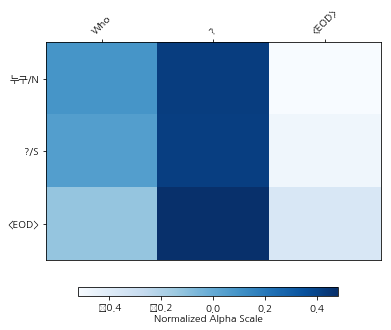

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


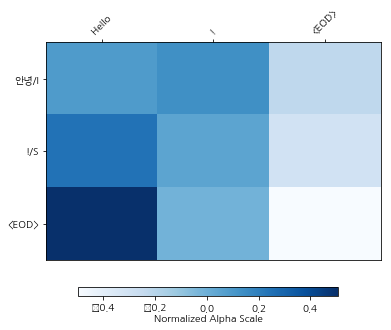

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


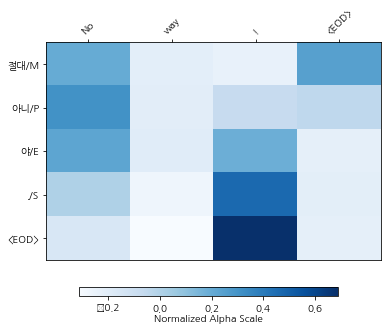

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


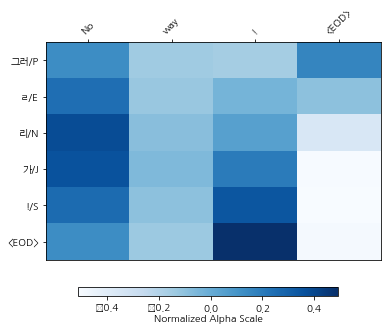

Epoch   0/200 Batch    0/227 - Loss:  7.199
[[[7.72936630e-08 4.07087282e-06 9.30211318e-05 1.27854245e-03
   1.07275276e-02 5.78259118e-02 2.12746561e-01 7.17324257e-01
   0.00000000e+00 0.00000000e+00]
  [1.07889927e-13 3.22493005e-11 6.06013195e-09 5.84812653e-07
   2.64625924e-05 5.77290251e-04 6.98651467e-03 4.79628853e-02
   2.14115232e-01 7.30331063e-01]
  [9.74127931e-11 2.40272886e-08 2.80919539e-06 1.12584436e-04
   1.62035204e-03 1.24071240e-02 5.86945936e-02 2.22553045e-01
   7.04609454e-01 0.00000000e+00]
  [2.31097911e-05 3.81382299e-04 4.87824017e-03 4.01512720e-02
   2.01244771e-01 7.53321230e-01 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[1.00835273e-07 4.78744005e-06 1.12226669e-04 1.52260216e-03
   1.28108906e-02 6.66346177e-02 2.34691486e-01 6.84223294e-01
   0.00000000e+00 0.00000000e+00]
  [3.60040079e-12 5.00384623e-10 4.90482215e-08 2.52563859e-06
   6.77217686e-05 1.02692004e-03 1.01134917e-02 5.95081002e-02
   2.35889241e-01 6.93391979

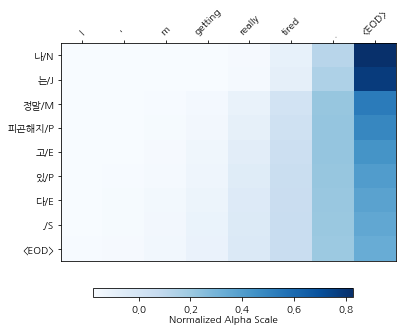

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


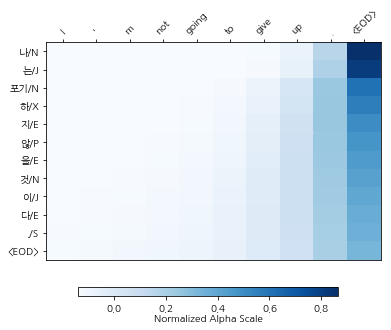

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


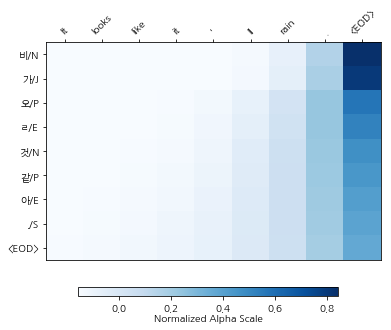

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


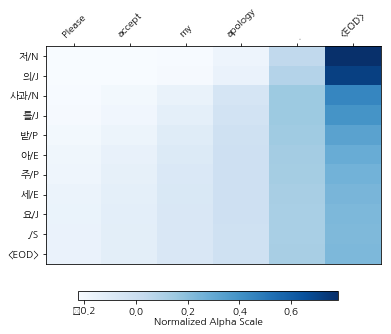

Epoch   0/200 Batch  100/227 - Loss:  4.628
[[[2.75014759e-06 2.13655912e-05 1.05962950e-04 3.89900524e-04
   1.33425603e-03 4.73496085e-03 1.76945981e-02 5.98981492e-02
   1.42957687e-01 2.43304253e-01 2.58899212e-01 1.62103891e-01
   1.08553037e-01]
  [2.23130407e-03 6.32993132e-02 3.74842763e-01 4.87771988e-01
   7.05774799e-02 1.27408723e-03 3.05045887e-06 3.70133568e-09
   4.17816346e-12 1.80048182e-15 7.15517537e-19 0.00000000e+00
   0.00000000e+00]
  [2.50486664e-05 4.22431505e-04 6.20029680e-03 4.32944857e-02
   1.36314154e-01 1.98785275e-01 2.56161392e-01 2.24523798e-01
   1.08774558e-01 2.17850655e-02 3.71356565e-03 0.00000000e+00
   0.00000000e+00]
  [1.41253273e-04 1.46908965e-03 8.44172016e-03 3.80060188e-02
   1.08159006e-01 2.08548501e-01 2.77955025e-01 2.48236924e-01
   8.38145241e-02 2.52278727e-02 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[1.13797496e-08 1.62911732e-07 1.64443406e-06 1.30337839e-05
   8.33659942e-05 4.62270487e-04 2.44935532e-03 1.17870821e

   0.00000000e+00]]]
input: I couldn ' t get the cork out of the bottle . <EOD>
gener: 병/N 에서/J 코르크/N 를/J 빼/P ㄹ/E 수/N 없/P 었어/E ./S <EOD>


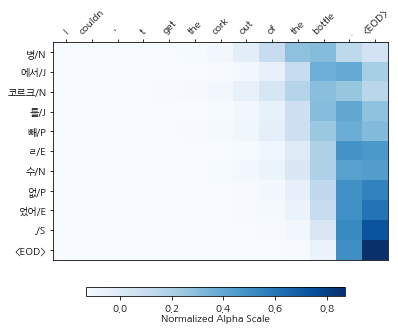

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


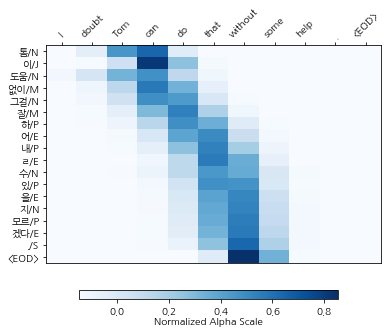

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


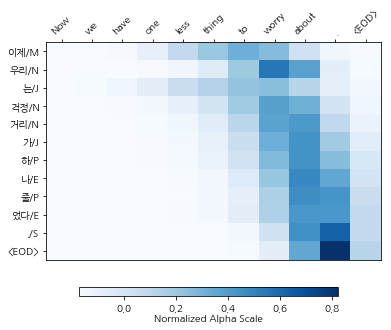

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


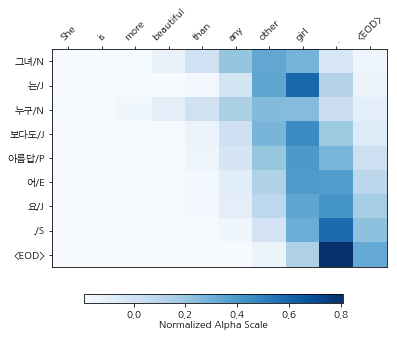

Epoch   0/200 Batch  200/227 - Loss:  4.844
Train perplexity: 146.69991
Epoch   1/200 Batch    0/227 - Loss:  5.291
Epoch   1/200 Batch  100/227 - Loss:  3.988
Epoch   1/200 Batch  200/227 - Loss:  4.559
Train perplexity: 63.74836
Epoch   2/200 Batch    0/227 - Loss:  4.586
Epoch   2/200 Batch  100/227 - Loss:  3.357
Epoch   2/200 Batch  200/227 - Loss:  4.288
Train perplexity: 44.48490
Epoch   3/200 Batch    0/227 - Loss:  3.904
Epoch   3/200 Batch  100/227 - Loss:  2.934
Epoch   3/200 Batch  200/227 - Loss:  4.114
Train perplexity: 32.95662
Epoch   4/200 Batch    0/227 - Loss:  3.649
Epoch   4/200 Batch  100/227 - Loss:  2.554
Epoch   4/200 Batch  200/227 - Loss:  3.786
Train perplexity: 23.99112
Epoch   5/200 Batch    0/227 - Loss:  3.381
Epoch   5/200 Batch  100/227 - Loss:  2.417
Epoch   5/200 Batch  200/227 - Loss:  3.431
Train perplexity: 17.86934
Epoch   6/200 Batch    0/227 - Loss:  2.297
Epoch   6/200 Batch  100/227 - Loss:  2.208
Epoch   6/200 Batch  200/227 - Loss:  3.662
T

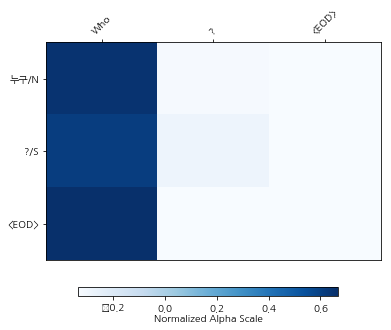

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


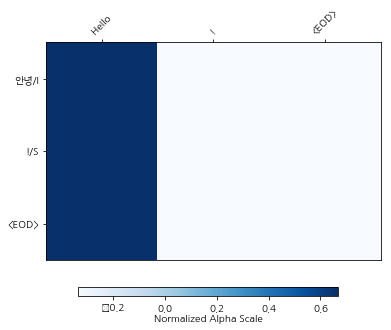

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


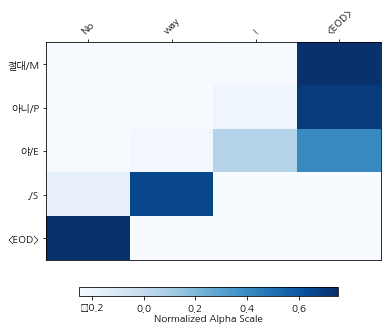

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


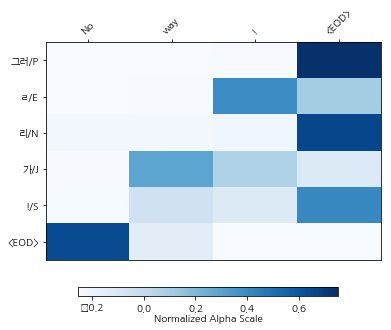

Epoch  10/200 Batch    0/227 - Loss:  1.558
[[[2.27042464e-34 1.17613999e-32 1.34725098e-35 3.50818116e-27
   4.56633425e-04 9.99397278e-01 1.45909697e-04 2.01636979e-07
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 2.59944420e-29 9.99826133e-01 1.73893321e-04
   1.73629028e-13 6.27730823e-17]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 1.75004600e-09 1.00000000e+00 1.36617286e-08
   1.78231128e-12 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 3.76973162e-29 7.95213044e-01
   2.04786956e-01 1.54364341e-10 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[5.76362362e-26 1.75411511e-26 1.40585363e-31 1.79760663e-31
   2.95947933e-10 9.98875678e-01 1.12436223e-03 4.49353355e-09
   0.00000000e+00 0.00000000e+00]
  [1.00672642e-32 3.17930926e-31 1.28006668e-31 2.90115881e-33
   9.70921600e-34 7.34616934e-27 3.67321220e-04 9.99609768e-01
   2.28400313e-05 4.74141615

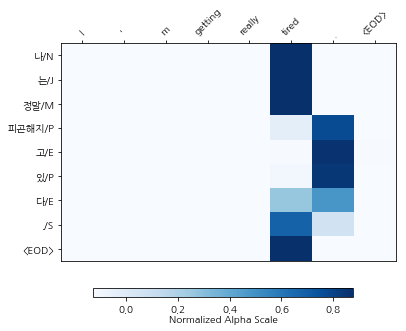

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


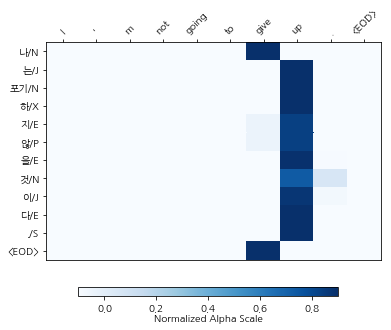

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


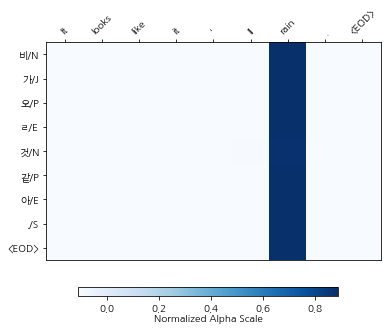

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


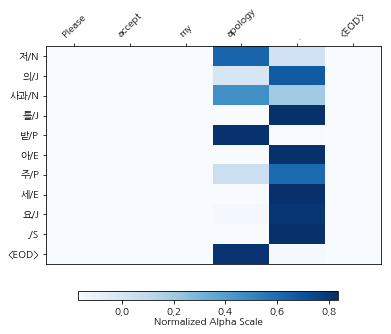

Epoch  10/200 Batch  100/227 - Loss:  1.386
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   2.28605067e-34 1.36036779e-21 8.17667870e-18 3.17195541e-11
   9.99999762e-01 2.02348375e-07 1.79597842e-19 1.25392636e-23
   1.81300544e-22]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 5.00077170e-26 7.62723015e-15 4.66848910e-03
   9.95278835e-01 5.26528784e-05 3.75184577e-08 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 9.53067861e-34 2.14262218e-05 9.99978542e-01
   8.19825571e-15 1.81576403e-21 5.79980398e-25 0.00000000e+00
   0.00000000e+00]
  [2.12078509e-35 2.54694188e-17 6.86458196e-04 2.64455050e-01
   7.34854579e-01 3.97540862e-06 1.14323178e-12 4.96733188e-14
   8.07463935e-18 1.90545397e-18 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   5.64742751e-31 1.21136299e-21 5.14347311e-16 1.89563920e

   0.00000000e+00]]]
input: I couldn ' t get the cork out of the bottle . <EOD>
gener: 병/N 에서/J 코르크/N 를/J 빼/P ㄹ/E 수/N 없/P 었어/E ./S <EOD>


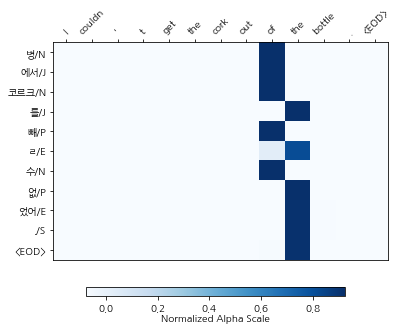

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


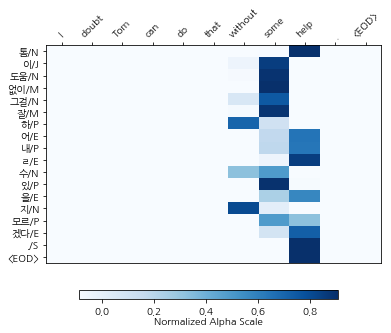

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


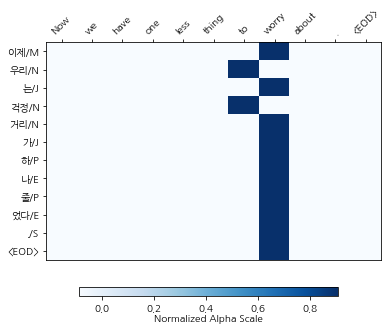

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


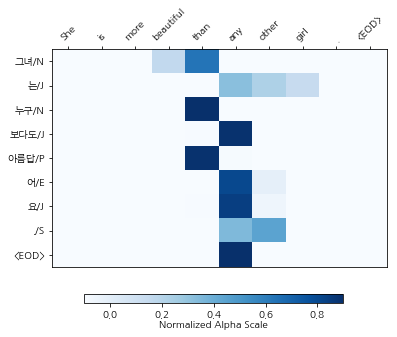

Epoch  10/200 Batch  200/227 - Loss:  2.361
Train perplexity: 5.71537
Epoch  11/200 Batch    0/227 - Loss:  1.236
Epoch  11/200 Batch  100/227 - Loss:  1.225
Epoch  11/200 Batch  200/227 - Loss:  1.841
Train perplexity: 4.45680
Epoch  12/200 Batch    0/227 - Loss:  1.713
Epoch  12/200 Batch  100/227 - Loss:  1.056
Epoch  12/200 Batch  200/227 - Loss:  1.794
Train perplexity: 3.69320
Epoch  13/200 Batch    0/227 - Loss:  0.622
Epoch  13/200 Batch  100/227 - Loss:  0.911
Epoch  13/200 Batch  200/227 - Loss:  1.709
Train perplexity: 3.12193
Epoch  14/200 Batch    0/227 - Loss:  0.370
Epoch  14/200 Batch  100/227 - Loss:  0.656
Epoch  14/200 Batch  200/227 - Loss:  1.422
Train perplexity: 2.67195
Epoch  15/200 Batch    0/227 - Loss:  0.579
Epoch  15/200 Batch  100/227 - Loss:  0.644
Epoch  15/200 Batch  200/227 - Loss:  1.370
Train perplexity: 2.47253
Epoch  16/200 Batch    0/227 - Loss:  0.834
Epoch  16/200 Batch  100/227 - Loss:  0.532
Epoch  16/200 Batch  200/227 - Loss:  0.939
Train pe

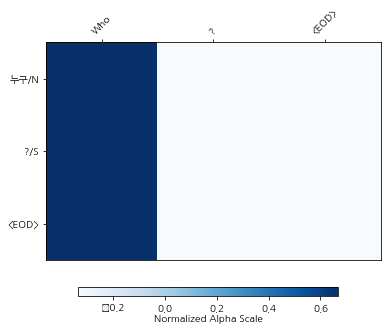

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


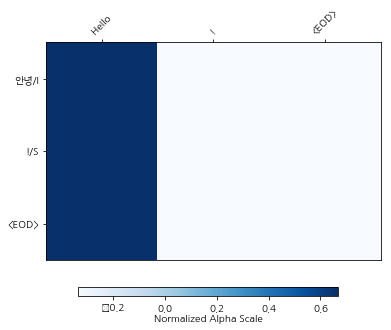

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


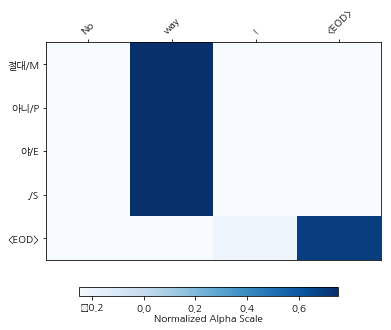

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


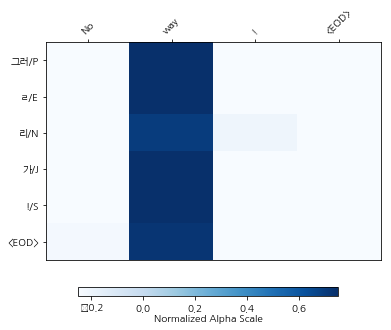

Epoch  20/200 Batch    0/227 - Loss:  0.641
[[[0.00000000e+00 0.00000000e+00 4.10044257e-38 4.43741615e-12
   9.99920368e-01 7.96034437e-05 1.09902684e-16 5.07283322e-27
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.07276897e-37
   4.42010907e-20 1.45857703e-04 9.99854088e-01 1.65604357e-12
   3.29693024e-23 2.64883360e-24]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   2.03320280e-33 2.10662127e-10 1.00000000e+00 4.75873296e-09
   2.44804268e-18 0.00000000e+00]
  [7.55252753e-36 6.50876902e-30 2.87538739e-07 6.38431132e-01
   3.61567408e-01 1.14551904e-06 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 6.50124822e-37 1.63216344e-22
   9.68398126e-08 9.99999881e-01 3.32295009e-08 2.36230448e-16
   0.00000000e+00 0.00000000e+00]
  [8.19789819e-32 1.43917729e-30 3.60665030e-32 6.19527841e-32
   4.29877141e-22 3.16689101e-12 2.05414440e-03 9.97939169e-01
   6.60171054e-06 1.79635347

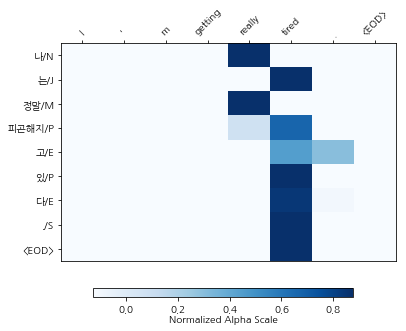

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


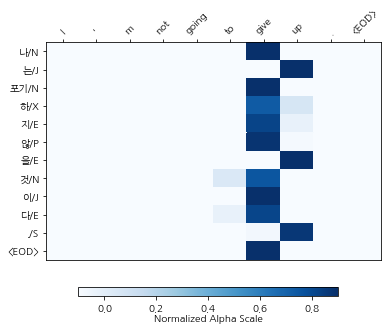

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


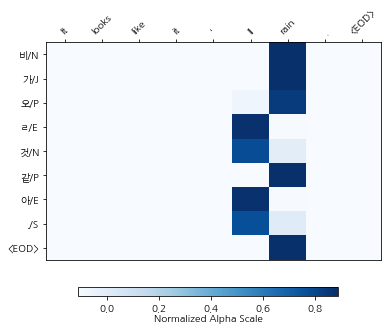

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


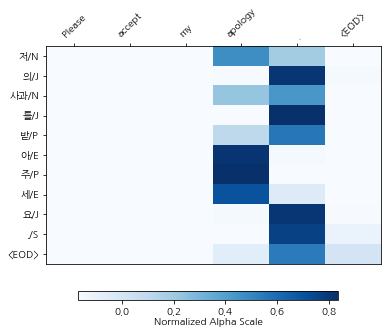

Epoch  20/200 Batch  100/227 - Loss:  0.275
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 1.99744696e-25 7.27205900e-21 2.11300619e-14
   5.48798766e-04 9.99442637e-01 4.64659615e-06 1.94939886e-09
   3.89827073e-06]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 5.44909773e-37 6.31386806e-34 6.95237054e-12
   1.00000000e+00 5.70167842e-08 1.58098708e-12 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   1.15931332e-31 8.64737973e-19 2.84421723e-03 9.97155786e-01
   4.79959143e-18 2.61627838e-27 1.77342131e-32 0.00000000e+00
   0.00000000e+00]
  [3.04727574e-32 1.39307692e-23 4.37957864e-11 7.29637918e-07
   1.00020566e-06 3.54013331e-02 8.91047478e-01 7.34729618e-02
   6.59744037e-05 1.04710498e-05 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[9.59573651e-38 8.25272512e-37 3.83610499e-36 2.28171697e-32
   7.60645743e-28 8.00245608e-20 1.23503968e-14 7.54151464e

   0.00000000e+00]]]
input: I couldn ' t get the cork out of the bottle . <EOD>
gener: 병/N 에서/J 코르크/N 를/J 빼/P ㄹ/E 수/N 없/P 었어/E ./S <EOD>


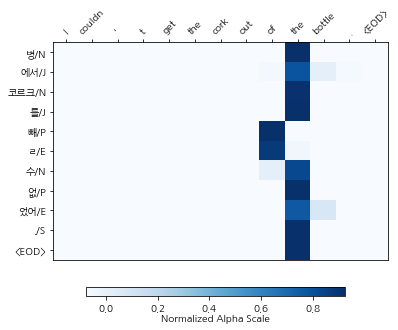

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


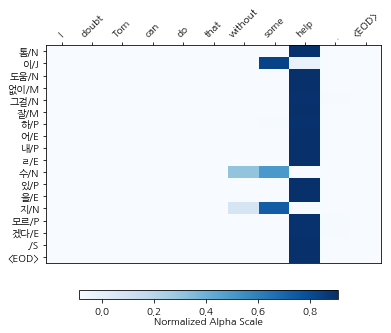

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


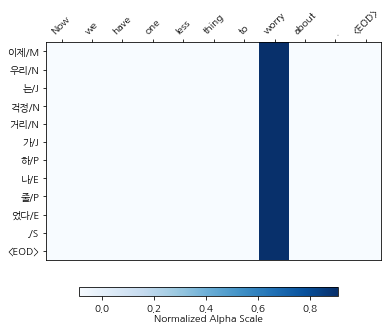

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


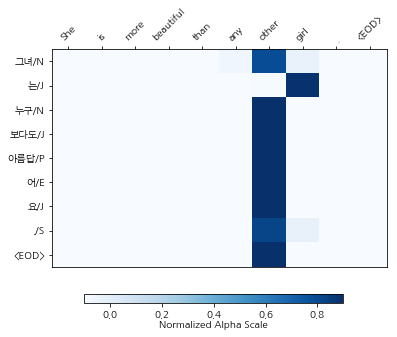

Epoch  20/200 Batch  200/227 - Loss:  0.408
Train perplexity: 1.49731
Epoch  21/200 Batch    0/227 - Loss:  0.490
Epoch  21/200 Batch  100/227 - Loss:  0.196
Epoch  21/200 Batch  200/227 - Loss:  0.415
Train perplexity: 1.41612
Epoch  22/200 Batch    0/227 - Loss:  0.752
Epoch  22/200 Batch  100/227 - Loss:  0.089
Epoch  22/200 Batch  200/227 - Loss:  0.339
Train perplexity: 1.39577
Epoch  23/200 Batch    0/227 - Loss:  1.053
Epoch  23/200 Batch  100/227 - Loss:  0.250
Epoch  23/200 Batch  200/227 - Loss:  0.190
Train perplexity: 1.53807
Epoch  24/200 Batch    0/227 - Loss:  0.555
Epoch  24/200 Batch  100/227 - Loss:  0.324
Epoch  24/200 Batch  200/227 - Loss:  0.282
Train perplexity: 1.42205
Epoch  25/200 Batch    0/227 - Loss:  0.718
Epoch  25/200 Batch  100/227 - Loss:  0.185
Epoch  25/200 Batch  200/227 - Loss:  0.258
Train perplexity: 1.36186
Epoch  26/200 Batch    0/227 - Loss:  0.214
Epoch  26/200 Batch  100/227 - Loss:  0.169
Epoch  26/200 Batch  200/227 - Loss:  0.352
Train pe

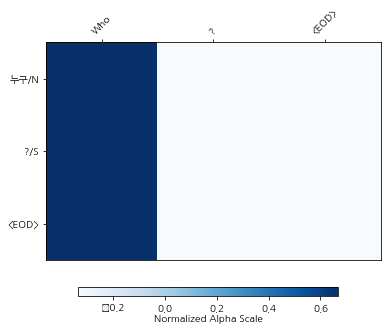

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


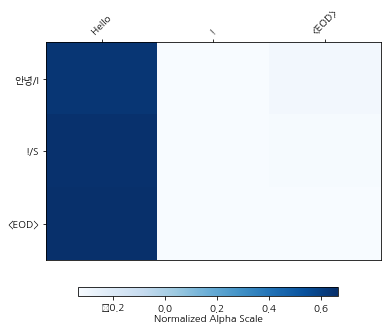

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


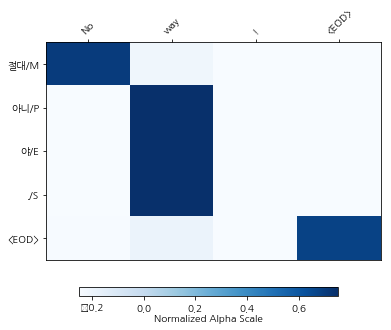

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


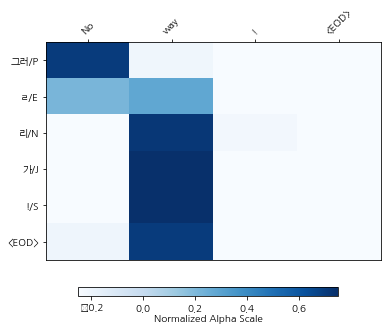

Epoch  30/200 Batch    0/227 - Loss:  0.604
[[[1.42534268e-36 0.00000000e+00 1.18742431e-38 8.33510372e-10
   9.99999523e-01 5.02522994e-07 9.20176587e-20 2.42957403e-26
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   2.34294231e-27 1.00000000e+00 1.27825632e-11 1.97753929e-32
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   1.96453142e-32 2.47022558e-09 1.00000000e+00 4.18035702e-12
   5.11281701e-18 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 6.25384644e-26 1.00000000e+00
   3.32427609e-15 2.07668719e-30 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[7.61757303e-35 0.00000000e+00 0.00000000e+00 4.70096980e-35
   1.65016090e-09 1.00000000e+00 1.47613265e-18 5.64924341e-30
   0.00000000e+00 0.00000000e+00]
  [2.43962446e-20 3.28637026e-27 0.00000000e+00 0.00000000e+00
   1.30443022e-24 1.33703137e-08 9.87242818e-01 1.27571812e-02
   6.96062430e-10 3.28611616

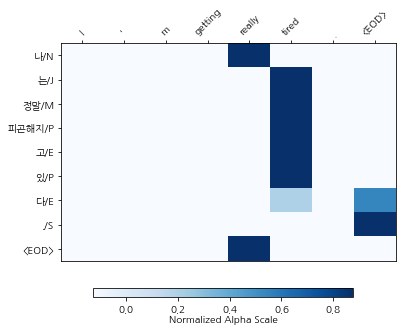

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


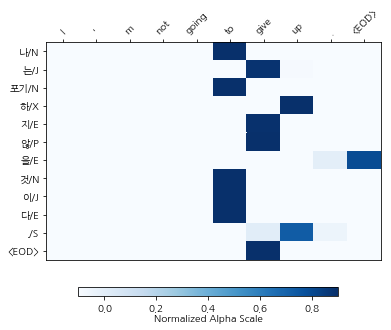

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


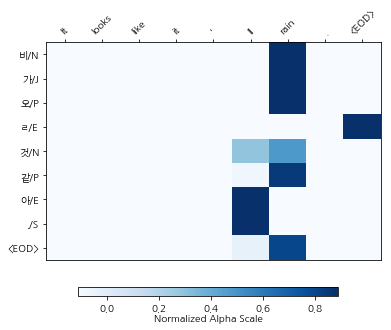

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


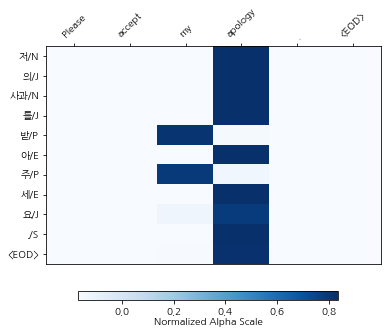

Epoch  30/200 Batch  100/227 - Loss:  0.046
[[[0.00000000e+00 2.33581683e-36 1.22749378e-29 6.32381646e-19
   6.88730370e-06 1.50187999e-01 4.19579670e-02 2.14056126e-04
   4.41780835e-01 3.65380138e-01 4.72152722e-04 4.32354241e-09
   4.10512735e-10]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 3.44194620e-32 2.96413206e-11
   1.00000000e+00 5.72908826e-14 4.91715137e-19 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   7.04176424e-37 9.89935889e-13 1.00000000e+00 8.78335907e-23
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [5.02264015e-23 1.29085116e-08 9.99957681e-01 1.59811570e-05
   2.18469600e-11 1.53610227e-08 5.04287357e-07 2.57753018e-05
   4.46981341e-11 1.26790016e-14 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[0.00000000e+00 1.18996012e-37 4.27748430e-38 1.46198407e-31
   2.94559242e-24 4.50475282e-18 7.78871900e-09 2.00047270e

   0.00000000e+00]]]
input: I couldn ' t get the cork out of the bottle . <EOD>
gener: 병/N 에서/J 코르크/N 를/J 빼/P ㄹ/E 수/N 없/P 었어/E ./S <EOD>


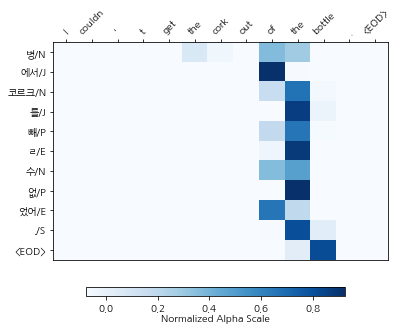

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


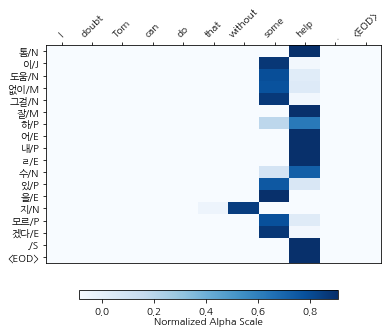

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


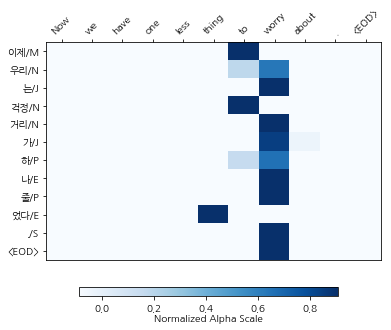

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


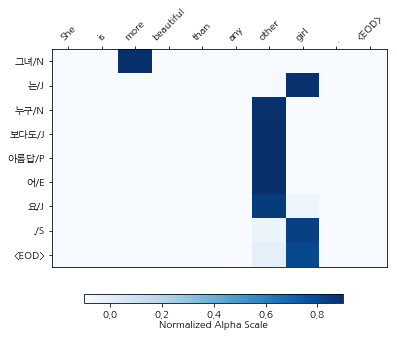

Epoch  30/200 Batch  200/227 - Loss:  0.113
Train perplexity: 1.20274
Epoch  31/200 Batch    0/227 - Loss:  0.389
Epoch  31/200 Batch  100/227 - Loss:  0.187
Epoch  31/200 Batch  200/227 - Loss:  0.275
Train perplexity: 1.27379
Epoch  32/200 Batch    0/227 - Loss:  0.237
Epoch  32/200 Batch  100/227 - Loss:  0.177
Epoch  32/200 Batch  200/227 - Loss:  0.213
Train perplexity: 1.32576
Epoch  33/200 Batch    0/227 - Loss:  0.527
Epoch  33/200 Batch  100/227 - Loss:  0.058
Epoch  33/200 Batch  200/227 - Loss:  0.285
Train perplexity: 1.30871
Epoch  34/200 Batch    0/227 - Loss:  0.704
Epoch  34/200 Batch  100/227 - Loss:  0.160
Epoch  34/200 Batch  200/227 - Loss:  0.349
Train perplexity: 1.33822
Epoch  35/200 Batch    0/227 - Loss:  0.482
Epoch  35/200 Batch  100/227 - Loss:  0.059
Epoch  35/200 Batch  200/227 - Loss:  0.113
Train perplexity: 1.34710
Epoch  36/200 Batch    0/227 - Loss:  0.423
Epoch  36/200 Batch  100/227 - Loss:  0.056
Epoch  36/200 Batch  200/227 - Loss:  0.170
Train pe

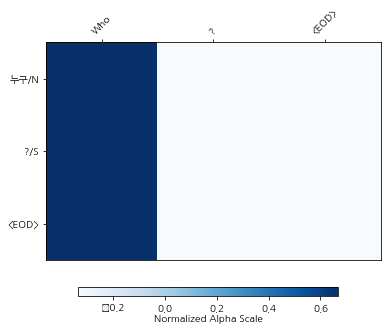

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


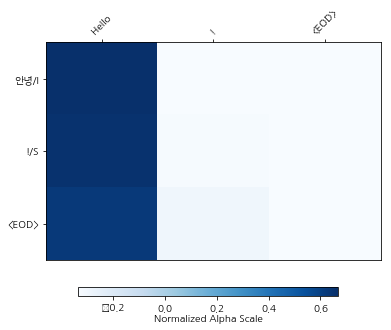

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


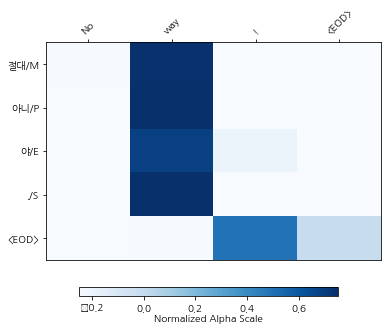

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


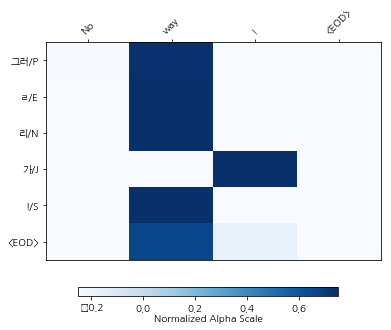

Epoch  40/200 Batch    0/227 - Loss:  0.655
[[[0.00000000e+00 0.00000000e+00 1.78244763e-33 4.07079351e-05
   9.98434722e-01 1.52457913e-03 5.19112041e-18 2.33752009e-25
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   6.50346840e-25 9.88417089e-01 1.15828514e-02 2.21750837e-19
   1.07807419e-29 1.81227961e-29]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   1.31518136e-12 9.78639960e-01 2.13601161e-02 2.38527803e-15
   1.07673290e-17 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 4.75586757e-12 1.00000000e+00
   6.11293039e-14 8.38165595e-22 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[3.09848097e-27 8.49755639e-32 4.40650799e-24 1.39795153e-08
   9.82854366e-01 1.71456318e-02 1.48788588e-14 6.12035398e-23
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   2.98447765e-22 1.25553220e-06 9.98283625e-01 1.71515124e-03
   6.89609134e-11 4.52835799

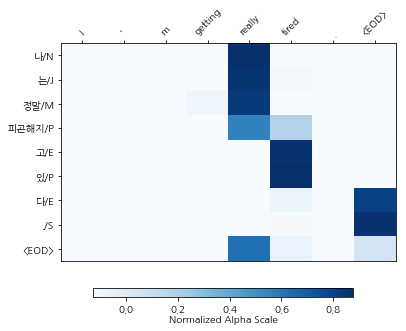

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


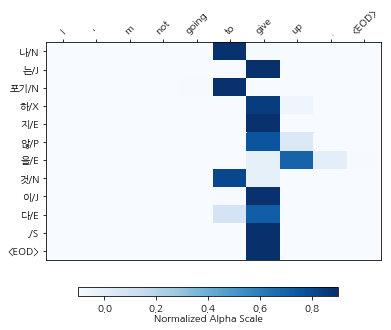

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


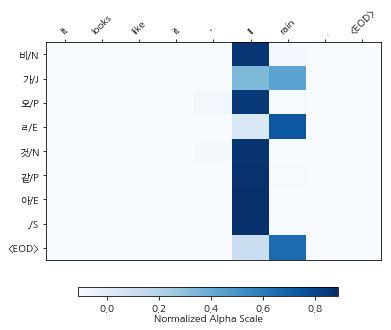

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


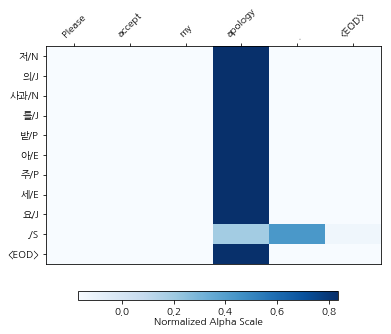

Epoch  40/200 Batch  100/227 - Loss:  0.023
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 2.31673773e-33 6.67574745e-29
   1.48228391e-12 9.99718964e-01 2.81030749e-04 2.17072129e-12
   7.59147693e-12]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 2.01698550e-32 6.75878034e-20 1.31319233e-04
   9.99868631e-01 1.44193446e-20 1.42093910e-20 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 3.50482465e-27 1.00000000e+00 1.46873048e-17
   5.34500103e-32 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 6.79693920e-31 7.19951578e-15
   1.42385881e-10 7.01632234e-05 4.90950188e-04 9.99438822e-01
   4.51639393e-09 7.56777141e-11 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 1.27743713e-37 5.56156282e-30 4.80148811e

   0.00000000e+00]]]
input: I couldn ' t get the cork out of the bottle . <EOD>
gener: 병/N 에서/J 코르크/N 를/J 빼/P ㄹ/E 수/N 없/P 었어/E ./S <EOD>


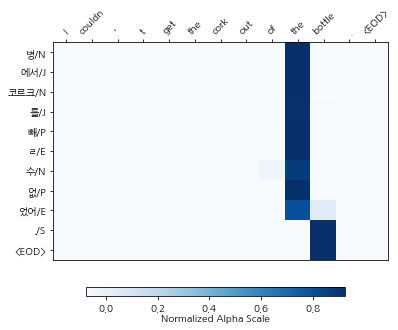

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


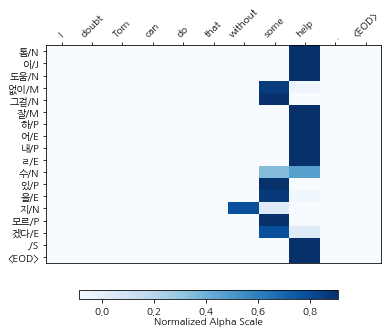

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


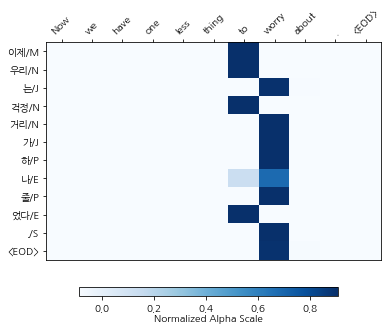

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


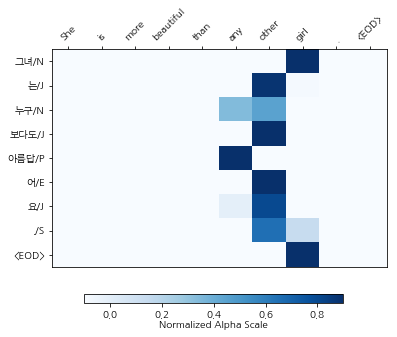

Epoch  40/200 Batch  200/227 - Loss:  0.078
Train perplexity: 1.16479
Epoch  41/200 Batch    0/227 - Loss:  1.373
Epoch  41/200 Batch  100/227 - Loss:  0.045
Epoch  41/200 Batch  200/227 - Loss:  0.129
Train perplexity: 1.18185
Epoch  42/200 Batch    0/227 - Loss:  0.383
Epoch  42/200 Batch  100/227 - Loss:  0.212
Epoch  42/200 Batch  200/227 - Loss:  0.109
Train perplexity: 1.17378
Epoch  43/200 Batch    0/227 - Loss:  0.661
Epoch  43/200 Batch  100/227 - Loss:  0.076
Epoch  43/200 Batch  200/227 - Loss:  0.050
Train perplexity: 1.17528
Epoch  44/200 Batch    0/227 - Loss:  0.188
Epoch  44/200 Batch  100/227 - Loss:  0.136
Epoch  44/200 Batch  200/227 - Loss:  0.444
Train perplexity: 1.28142
Epoch  45/200 Batch    0/227 - Loss:  0.760
Epoch  45/200 Batch  100/227 - Loss:  0.203
Epoch  45/200 Batch  200/227 - Loss:  0.543
Train perplexity: 1.31125
Epoch  46/200 Batch    0/227 - Loss:  0.349
Epoch  46/200 Batch  100/227 - Loss:  0.195
Epoch  46/200 Batch  200/227 - Loss:  0.273
Train pe

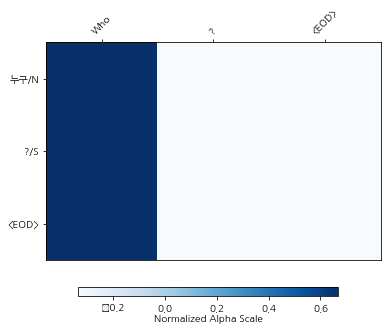

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


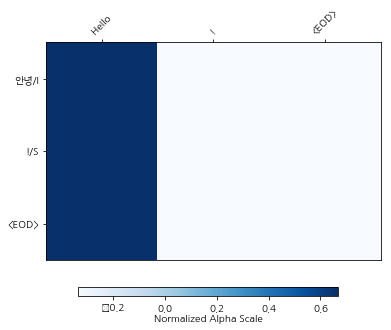

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


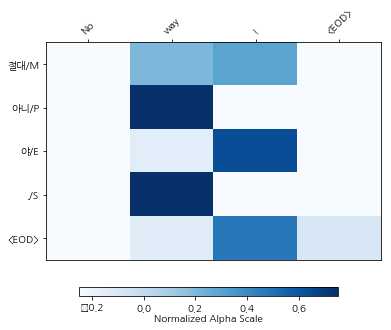

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


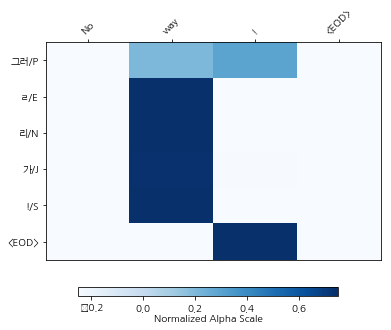

Epoch  50/200 Batch    0/227 - Loss:  0.572
[[[3.92922285e-33 0.00000000e+00 7.77758243e-26 3.54891759e-03
   9.67770875e-01 2.86802277e-02 4.74586631e-16 1.89220870e-24
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   5.41031882e-34 1.95872728e-02 9.80412662e-01 5.68683319e-21
   2.28627876e-36 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.63531650e-34
   1.84173579e-10 9.99955773e-01 4.42547680e-05 3.28344566e-16
   1.15745600e-19 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 4.51263588e-07 9.99999523e-01
   3.63590661e-23 4.10593171e-31 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 1.01750268e-33 4.72307003e-12
   9.99259889e-01 7.40068906e-04 1.83710578e-24 1.75364855e-30
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   1.28893523e-22 1.88249083e-09 9.99837518e-01 1.62471435e-04
   2.37680701e-16 1.22203879

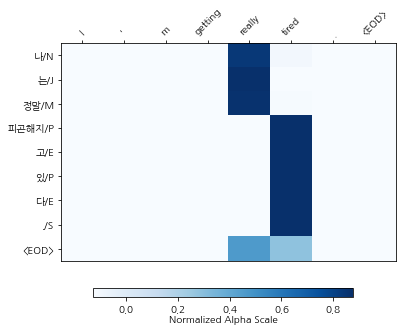

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


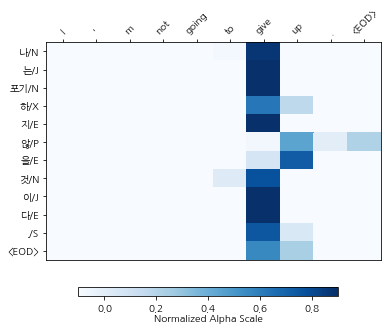

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


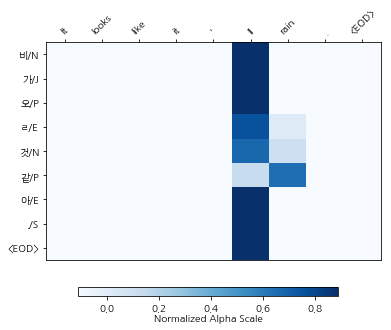

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


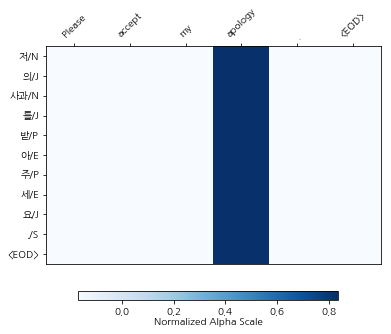

Epoch  50/200 Batch  100/227 - Loss:  0.038
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 1.53259564e-34 4.90797019e-13 1.28229335e-01
   8.71770680e-01 6.21518323e-11 3.04273851e-26 4.99197052e-38
   8.19653047e-38]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 8.39159071e-25 3.36595595e-12 8.87483001e-01
   1.12517022e-01 1.47746215e-25 1.56348965e-26 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   1.04595412e-30 1.00000000e+00 6.80536226e-12 6.64835223e-34
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [4.71045358e-38 6.90761132e-37 2.15868348e-17 5.00321585e-05
   7.18806386e-01 2.81142533e-01 9.98257747e-07 1.53680935e-09
   2.01892738e-16 4.28955378e-16 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 6.23886902e-28 6.70824811e

   0.00000000e+00]]]
input: I couldn ' t get the cork out of the bottle . <EOD>
gener: 병/N 에서/J 코르크/N 를/J 빼/P ㄹ/E 수/N 없/P 었어/E ./S <EOD>


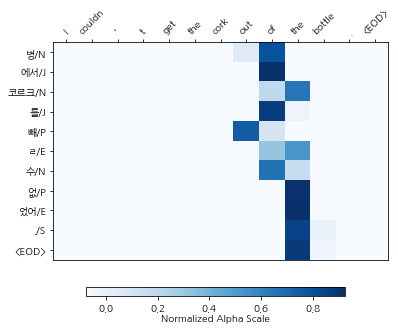

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


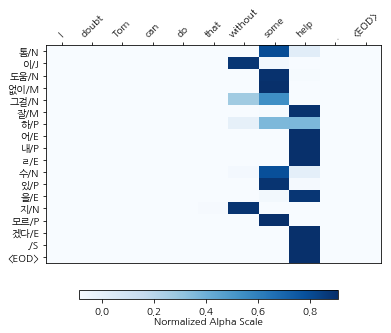

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


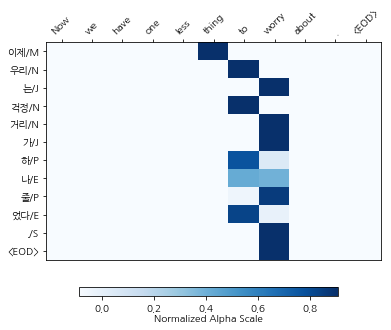

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


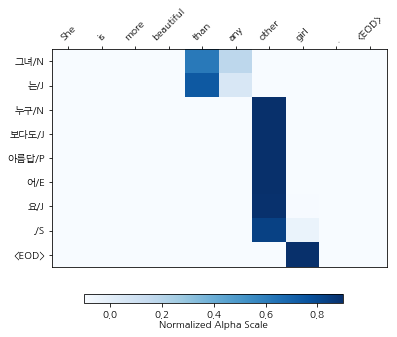

Epoch  50/200 Batch  200/227 - Loss:  0.082
Train perplexity: 1.17705
Epoch  51/200 Batch    0/227 - Loss:  0.525
Epoch  51/200 Batch  100/227 - Loss:  0.100
Epoch  51/200 Batch  200/227 - Loss:  0.102
Train perplexity: 1.20186
Epoch  52/200 Batch    0/227 - Loss:  0.160
Epoch  52/200 Batch  100/227 - Loss:  0.125
Epoch  52/200 Batch  200/227 - Loss:  0.210
Train perplexity: 1.17825
Epoch  53/200 Batch    0/227 - Loss:  0.396
Epoch  53/200 Batch  100/227 - Loss:  0.190
Epoch  53/200 Batch  200/227 - Loss:  0.121
Train perplexity: 1.14679
Epoch  54/200 Batch    0/227 - Loss:  0.273
Epoch  54/200 Batch  100/227 - Loss:  0.017
Epoch  54/200 Batch  200/227 - Loss:  0.072
Train perplexity: 1.13090
Epoch  55/200 Batch    0/227 - Loss:  0.282
Epoch  55/200 Batch  100/227 - Loss:  0.049
Epoch  55/200 Batch  200/227 - Loss:  0.025
Train perplexity: 1.12356
Epoch  56/200 Batch    0/227 - Loss:  0.280
Epoch  56/200 Batch  100/227 - Loss:  0.037
Epoch  56/200 Batch  200/227 - Loss:  0.034
Train pe

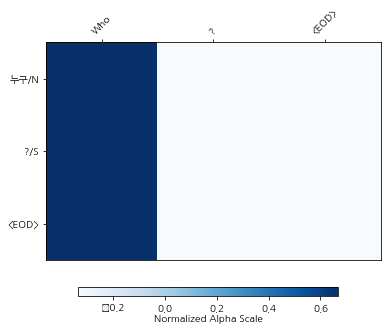

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


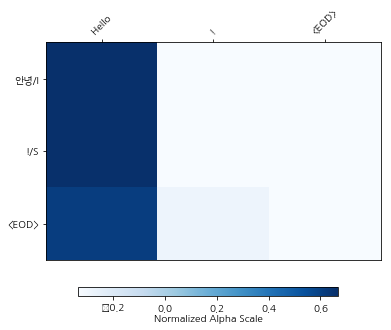

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


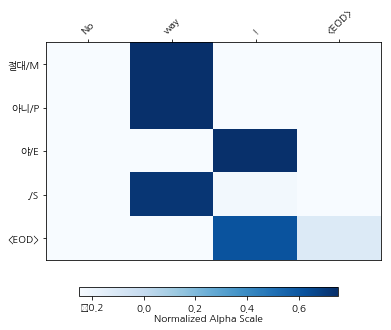

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


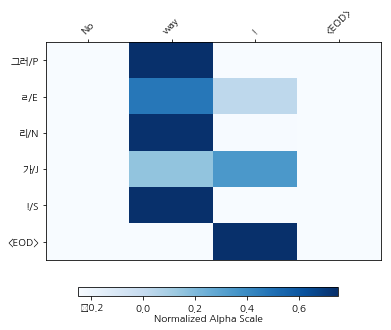

Epoch  60/200 Batch    0/227 - Loss:  0.404
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.57147024e-14
   3.92736052e-04 9.99607265e-01 6.64962068e-19 4.13580328e-30
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 1.48681414e-10 1.00000000e+00 2.40905859e-19
   3.95648303e-36 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   1.38988961e-21 1.00000000e+00 5.37847631e-12 1.31036717e-34
   0.00000000e+00 0.00000000e+00]
  [3.70593167e-32 1.49541995e-24 1.73733272e-02 9.82364833e-01
   2.61853274e-04 4.16483428e-12 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 4.33528636e-29 5.48972853e-15
   8.52300203e-04 9.99147654e-01 7.91443869e-16 2.76658720e-22
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   1.69296418e-34 2.17352243e-12 9.33270752e-01 6.67292476e-02
   9.89780147e-10 6.13483941

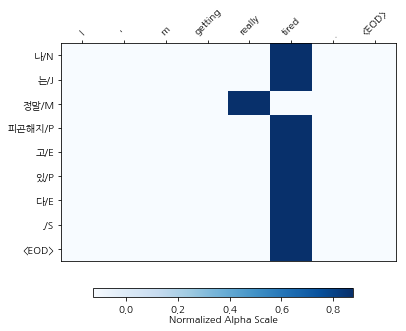

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


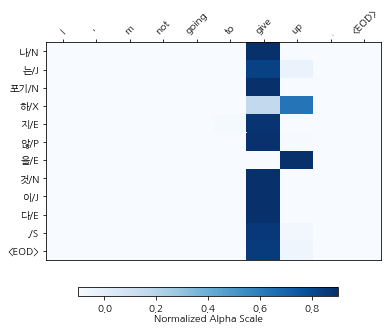

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


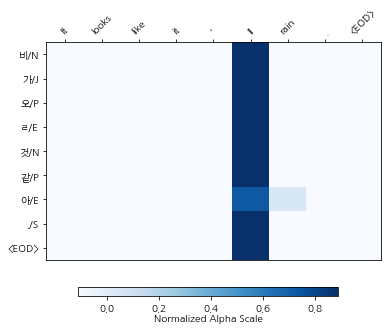

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


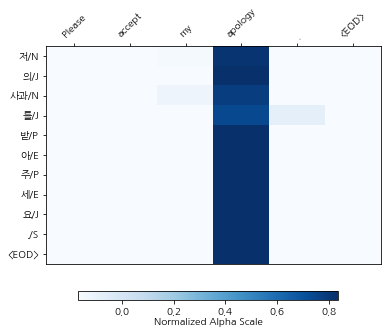

Epoch  60/200 Batch  100/227 - Loss:  0.044
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 5.41971372e-28
   5.45467483e-05 9.99932766e-01 1.26011118e-05 2.50362837e-23
   1.09314891e-24]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 7.10948998e-28 4.42794530e-08
   1.00000000e+00 6.78598850e-22 1.75221599e-25 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 6.20261655e-13 1.00000000e+00 3.40545167e-27
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00802527e-37
   8.17740769e-15 1.14182808e-06 3.05282742e-06 9.99995708e-01
   5.21703123e-13 2.78715638e-19 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 1.55929502e-29 4.18250273e

   0.00000000e+00]]]
input: I couldn ' t get the cork out of the bottle . <EOD>
gener: 병/N 에서/J 코르크/N 를/J 빼/P ㄹ/E 수/N 없/P 었어/E ./S <EOD>


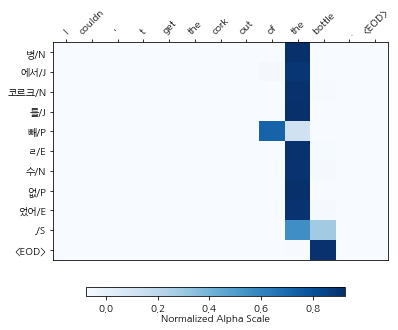

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


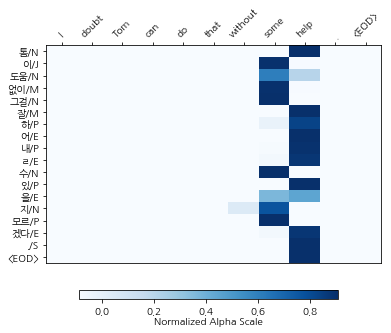

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


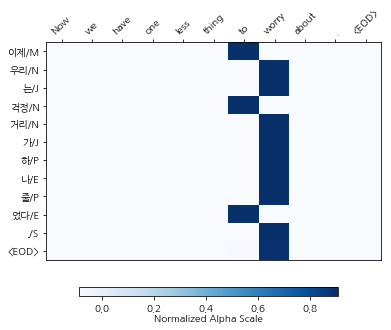

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


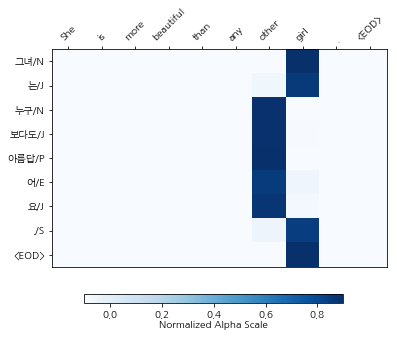

Epoch  60/200 Batch  200/227 - Loss:  0.028
Train perplexity: 1.16538
Epoch  61/200 Batch    0/227 - Loss:  0.167
Epoch  61/200 Batch  100/227 - Loss:  0.146
Epoch  61/200 Batch  200/227 - Loss:  0.037
Train perplexity: 1.18609
Epoch  62/200 Batch    0/227 - Loss:  0.548
Epoch  62/200 Batch  100/227 - Loss:  0.093
Epoch  62/200 Batch  200/227 - Loss:  0.084
Train perplexity: 1.22891
Epoch  63/200 Batch    0/227 - Loss:  0.205
Epoch  63/200 Batch  100/227 - Loss:  0.149
Epoch  63/200 Batch  200/227 - Loss:  0.545
Train perplexity: 1.27064
Epoch  64/200 Batch    0/227 - Loss:  0.188
Epoch  64/200 Batch  100/227 - Loss:  0.186
Epoch  64/200 Batch  200/227 - Loss:  0.175
Train perplexity: 1.28054
Epoch  65/200 Batch    0/227 - Loss:  0.585
Epoch  65/200 Batch  100/227 - Loss:  0.167
Epoch  65/200 Batch  200/227 - Loss:  0.249
Train perplexity: 1.20789
Epoch  66/200 Batch    0/227 - Loss:  0.140
Epoch  66/200 Batch  100/227 - Loss:  0.035
Epoch  66/200 Batch  200/227 - Loss:  0.221
Train pe

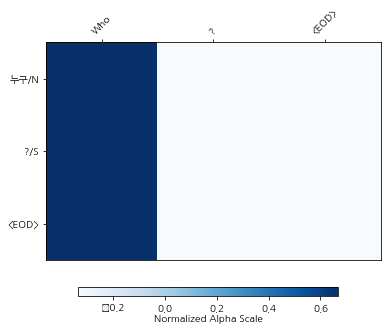

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


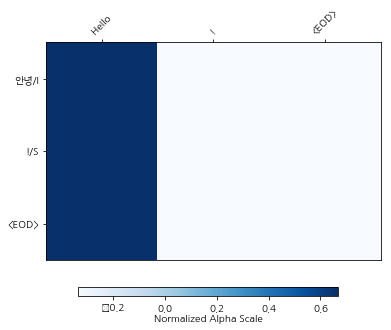

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


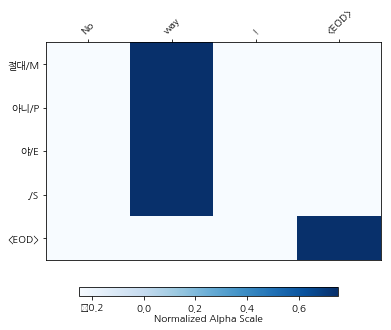

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


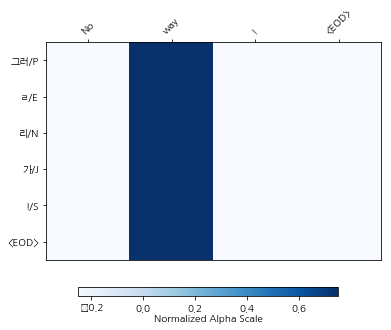

Epoch  70/200 Batch    0/227 - Loss:  0.218
[[[0.00000000e+00 0.00000000e+00 4.52053195e-38 8.01670050e-11
   9.99989629e-01 1.04165229e-05 1.72222795e-29 6.75608544e-37
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 2.05998812e-11 1.00000000e+00 1.95682703e-14
   6.45265073e-29 1.23319584e-32]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   1.92736970e-34 9.99999881e-01 1.36809533e-07 7.46616064e-20
   1.97313785e-25 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 6.57504832e-04 9.99342501e-01
   3.24047339e-21 1.06650176e-28 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 4.53807793e-32 9.13398924e-21
   9.72769976e-10 1.00000000e+00 7.10716726e-18 3.87985219e-22
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.55917301e-35
   1.65275173e-25 2.43120246e-10 9.98941600e-01 1.05842075e-03
   5.26024927e-12 1.05547103

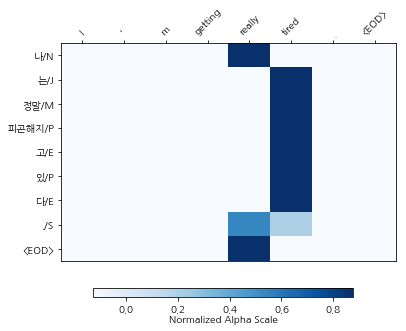

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


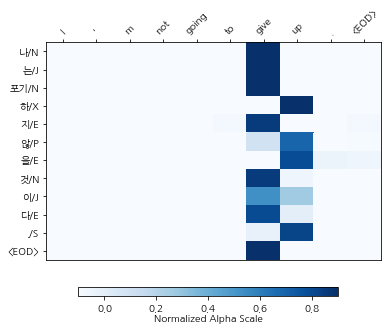

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


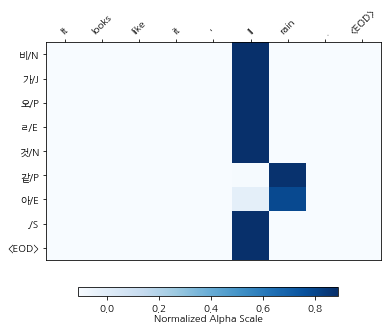

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


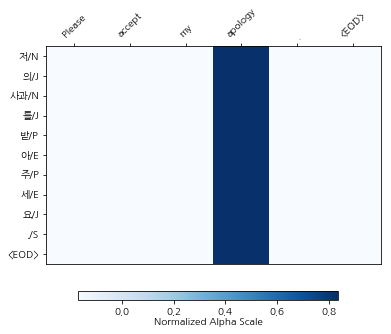

Epoch  70/200 Batch  100/227 - Loss:  0.107
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   4.01393991e-17 1.00000000e+00 1.85858043e-13 9.97325707e-31
   1.06312740e-29]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 9.33418499e-30 9.94342566e-01
   5.65748848e-03 1.38243387e-19 1.89388647e-18 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 2.83253649e-29 1.00000000e+00 3.13416881e-16
   5.48224761e-30 4.22455502e-38 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 1.00441745e-34 6.19124890e-12 1.00000000e+00
   3.54627289e-20 2.48130029e-23 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 1.10596264e-29 2.20261120e

   0.00000000e+00]]]
input: I couldn ' t get the cork out of the bottle . <EOD>
gener: 병/N 에서/J 코르크/N 를/J 빼/P ㄹ/E 수/N 없/P 었어/E ./S <EOD>


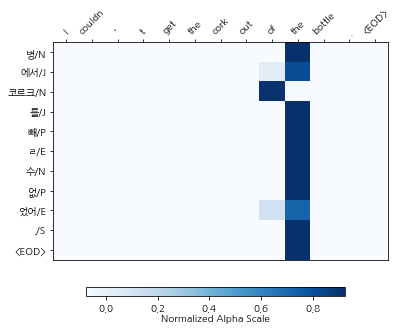

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


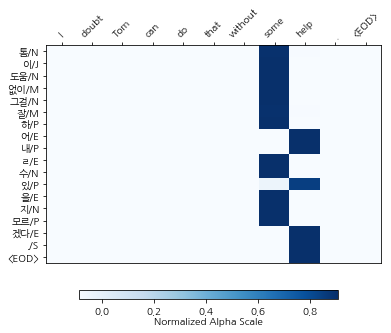

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


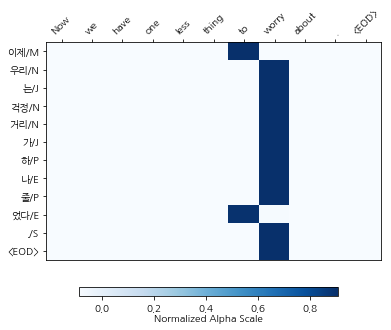

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


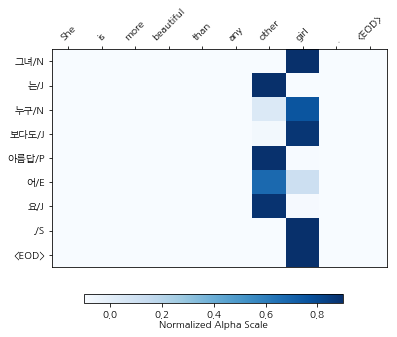

Epoch  70/200 Batch  200/227 - Loss:  0.123
Train perplexity: 1.10930
Epoch  71/200 Batch    0/227 - Loss:  0.193
Epoch  71/200 Batch  100/227 - Loss:  0.014
Epoch  71/200 Batch  200/227 - Loss:  0.126
Train perplexity: 1.11414
Epoch  72/200 Batch    0/227 - Loss:  1.616
Epoch  72/200 Batch  100/227 - Loss:  0.013
Epoch  72/200 Batch  200/227 - Loss:  0.093
Train perplexity: 1.14672
Epoch  73/200 Batch    0/227 - Loss:  0.544
Epoch  73/200 Batch  100/227 - Loss:  0.026
Epoch  73/200 Batch  200/227 - Loss:  0.028
Train perplexity: 1.16329
Epoch  74/200 Batch    0/227 - Loss:  0.680
Epoch  74/200 Batch  100/227 - Loss:  0.034
Epoch  74/200 Batch  200/227 - Loss:  0.069
Train perplexity: 1.19722
Epoch  75/200 Batch    0/227 - Loss:  0.273
Epoch  75/200 Batch  100/227 - Loss:  0.291
Epoch  75/200 Batch  200/227 - Loss:  0.296
Train perplexity: 1.20245
Epoch  76/200 Batch    0/227 - Loss:  0.405
Epoch  76/200 Batch  100/227 - Loss:  0.028
Epoch  76/200 Batch  200/227 - Loss:  0.250
Train pe

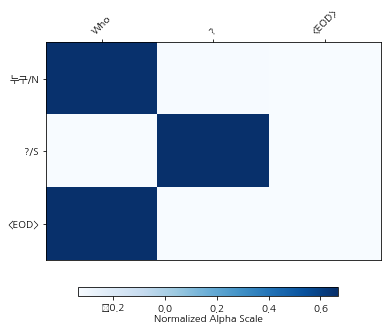

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


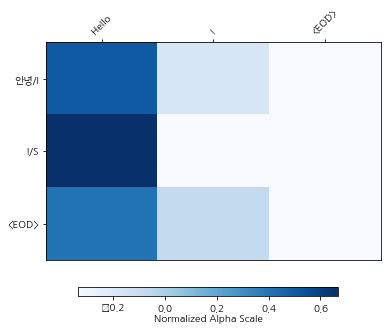

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


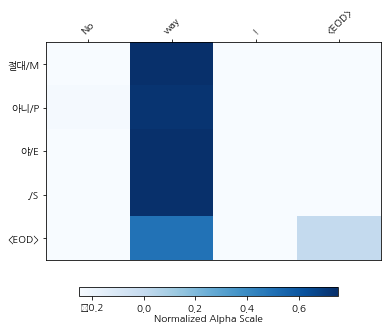

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


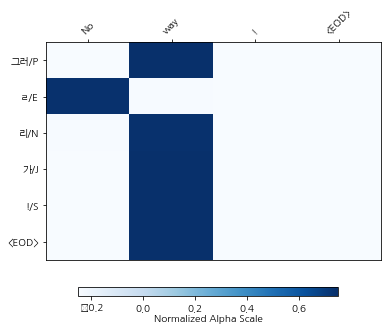

Epoch  80/200 Batch    0/227 - Loss:  0.507
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 5.17232725e-36
   9.14431551e-12 1.00000000e+00 1.59050902e-15 8.72890467e-25
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   1.16265748e-26 9.99972463e-01 2.75957336e-05 2.00120031e-16
   1.14624142e-24 1.51400844e-28]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   4.57218138e-19 9.99217868e-01 7.82135292e-04 3.85126122e-13
   1.02265456e-18 0.00000000e+00]
  [0.00000000e+00 1.53089669e-32 3.16701829e-01 6.83298111e-01
   4.15737260e-20 2.61731692e-26 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 3.94769978e-33
   2.30633573e-13 1.00000000e+00 3.06053518e-18 1.95367859e-26
   0.00000000e+00 0.00000000e+00]
  [1.98817535e-34 2.51130392e-35 4.07939519e-33 3.60056703e-30
   1.10885598e-18 1.99773640e-05 8.70940208e-01 1.29039794e-01
   2.11230700e-09 1.93444300

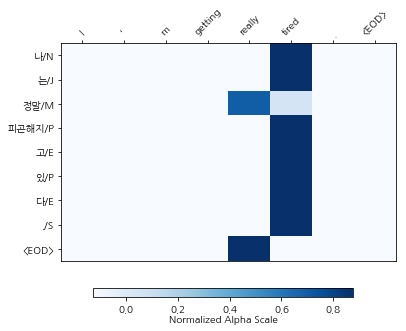

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


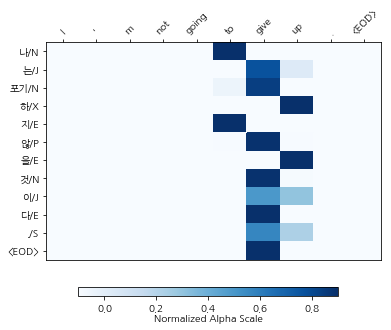

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


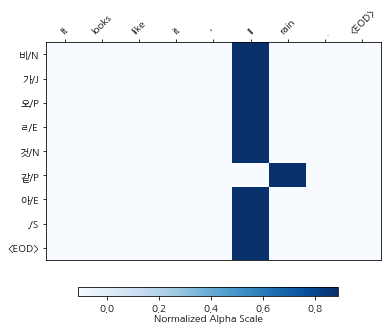

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


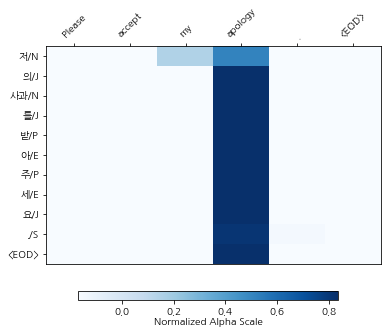

Epoch  80/200 Batch  100/227 - Loss:  0.106
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 7.38266424e-25
   9.85703082e-04 9.99014258e-01 7.40171542e-13 2.60894497e-19
   1.97286906e-19]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 4.04584217e-33 1.19538516e-22 1.00070292e-05
   9.99989986e-01 5.68417102e-12 4.25752126e-13 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 7.36265274e-18 1.00000000e+00 1.13823085e-14
   6.43306081e-37 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 3.14722685e-24 2.62894462e-09 1.00000000e+00
   7.48093306e-19 1.27943095e-20 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 2.51634684e

   0.00000000e+00]]]
input: I couldn ' t get the cork out of the bottle . <EOD>
gener: 병/N 에서/J 코르크/N 를/J 빼/P ㄹ/E 수/N 없/P 었어/E ./S <EOD>


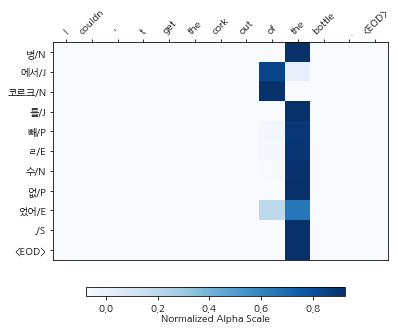

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


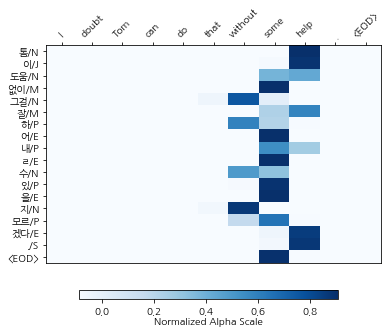

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


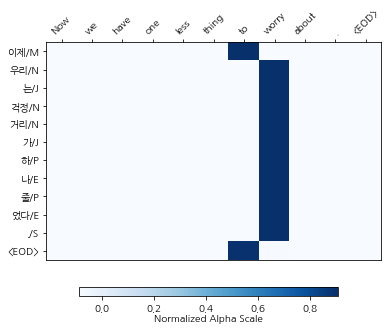

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


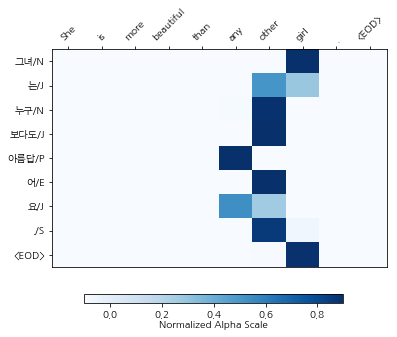

Epoch  80/200 Batch  200/227 - Loss:  0.015
Train perplexity: 1.12728
Epoch  81/200 Batch    0/227 - Loss:  0.390
Epoch  81/200 Batch  100/227 - Loss:  0.021
Epoch  81/200 Batch  200/227 - Loss:  0.020
Train perplexity: 1.12344
Epoch  82/200 Batch    0/227 - Loss:  0.143
Epoch  82/200 Batch  100/227 - Loss:  0.023
Epoch  82/200 Batch  200/227 - Loss:  0.017
Train perplexity: 1.13707
Epoch  83/200 Batch    0/227 - Loss:  0.455
Epoch  83/200 Batch  100/227 - Loss:  0.006
Epoch  83/200 Batch  200/227 - Loss:  0.091
Train perplexity: 1.12074
Epoch  84/200 Batch    0/227 - Loss:  0.213
Epoch  84/200 Batch  100/227 - Loss:  0.011
Epoch  84/200 Batch  200/227 - Loss:  0.175
Train perplexity: 1.14145
Epoch  85/200 Batch    0/227 - Loss:  0.291
Epoch  85/200 Batch  100/227 - Loss:  0.091
Epoch  85/200 Batch  200/227 - Loss:  0.096
Train perplexity: 1.15469
Epoch  86/200 Batch    0/227 - Loss:  0.245
Epoch  86/200 Batch  100/227 - Loss:  0.145
Epoch  86/200 Batch  200/227 - Loss:  0.034
Train pe

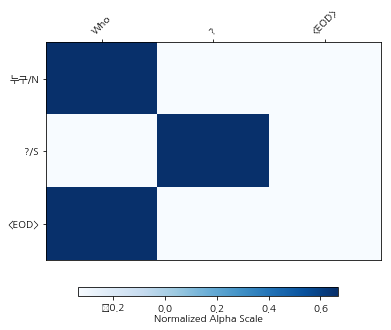

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


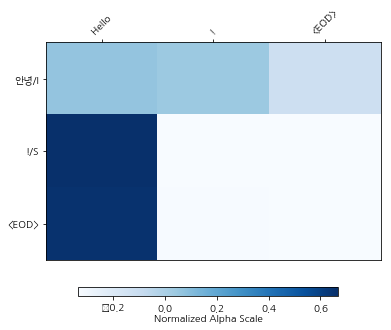

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


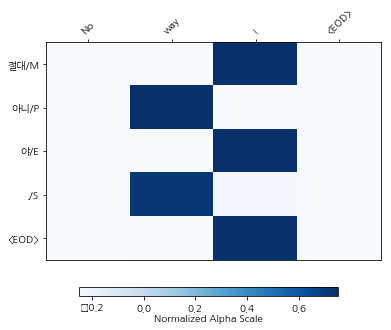

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


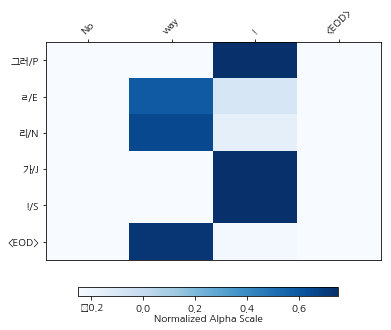

Epoch  90/200 Batch    0/227 - Loss:  0.448
[[[2.16651631e-38 0.00000000e+00 8.87942259e-34 3.27446268e-14
   1.15183198e-07 9.99999881e-01 4.40514150e-08 4.43417050e-17
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 1.89745188e-05 9.99981046e-01 2.14965193e-20
   1.33606112e-31 6.89287459e-31]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 3.20837915e-01 6.79162085e-01 2.93002409e-23
   1.65361088e-33 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 5.49160213e-05 9.99945045e-01
   2.50044631e-20 1.66209776e-25 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[3.66611875e-37 0.00000000e+00 1.30606110e-33 5.65264896e-15
   2.06958270e-10 1.00000000e+00 1.61119016e-14 1.13938314e-27
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.02706342e-33
   1.03831226e-19 3.34201141e-05 9.99951363e-01 1.52045186e-05
   1.40912903e-13 8.81585115

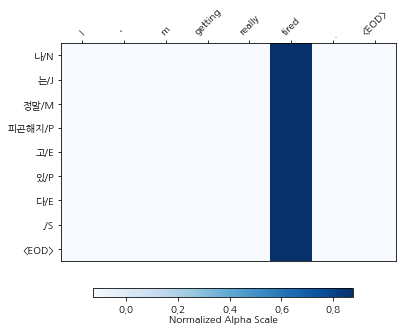

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


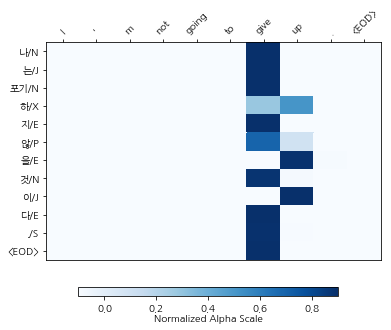

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


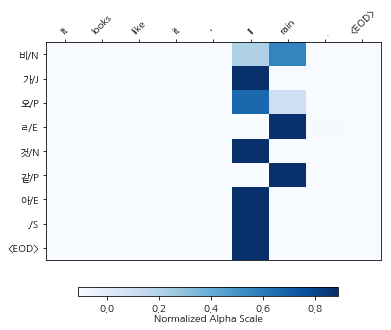

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


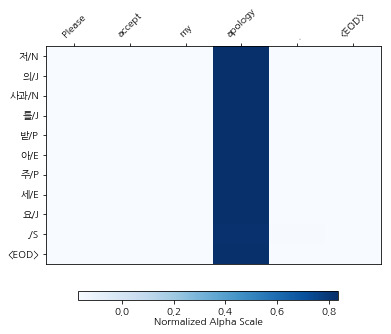

Epoch  90/200 Batch  100/227 - Loss:  0.123
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   3.05497425e-15 9.99923229e-01 7.67280508e-05 1.24743934e-20
   7.45442506e-22]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 2.43558756e-34 2.24875729e-10
   1.00000000e+00 8.72970188e-18 1.30664144e-22 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 1.00000000e+00 2.60454005e-08
   3.93178009e-20 1.72905653e-32 1.38559639e-36 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 1.45339191e-25 2.96677061e-09 1.00000000e+00
   9.48640106e-14 7.78028349e-17 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 2.85734847e

   0.00000000e+00]]]
input: I couldn ' t get the cork out of the bottle . <EOD>
gener: 병/N 에서/J 코르크/N 를/J 빼/P ㄹ/E 수/N 없/P 었어/E ./S <EOD>


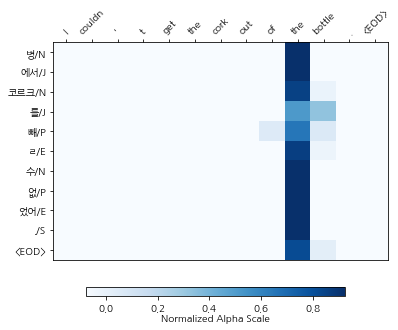

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


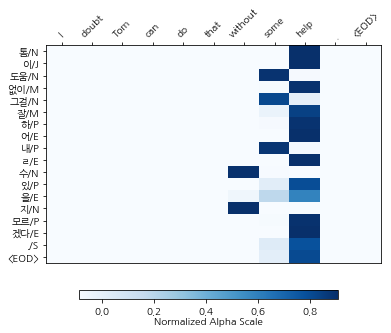

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


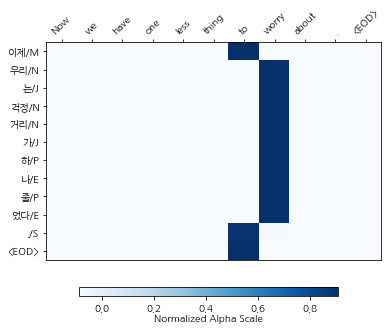

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


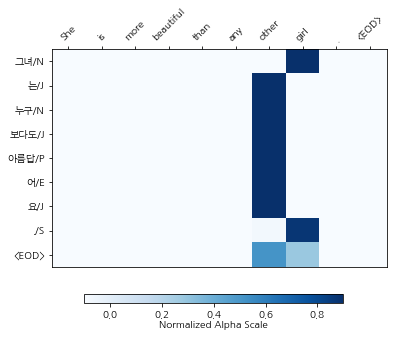

Epoch  90/200 Batch  200/227 - Loss:  0.371
Train perplexity: 1.13593
Epoch  91/200 Batch    0/227 - Loss:  0.169
Epoch  91/200 Batch  100/227 - Loss:  0.057
Epoch  91/200 Batch  200/227 - Loss:  0.145
Train perplexity: 1.15165
Epoch  92/200 Batch    0/227 - Loss:  0.201
Epoch  92/200 Batch  100/227 - Loss:  0.124
Epoch  92/200 Batch  200/227 - Loss:  0.385
Train perplexity: 1.16365
Epoch  93/200 Batch    0/227 - Loss:  0.345
Epoch  93/200 Batch  100/227 - Loss:  0.245
Epoch  93/200 Batch  200/227 - Loss:  0.133
Train perplexity: 1.21129
Epoch  94/200 Batch    0/227 - Loss:  0.243
Epoch  94/200 Batch  100/227 - Loss:  0.024
Epoch  94/200 Batch  200/227 - Loss:  0.126
Train perplexity: 1.16122
Epoch  95/200 Batch    0/227 - Loss:  0.388
Epoch  95/200 Batch  100/227 - Loss:  0.043
Epoch  95/200 Batch  200/227 - Loss:  0.072
Train perplexity: 1.14211
Epoch  96/200 Batch    0/227 - Loss:  0.232
Epoch  96/200 Batch  100/227 - Loss:  0.183
Epoch  96/200 Batch  200/227 - Loss:  0.154
Train pe

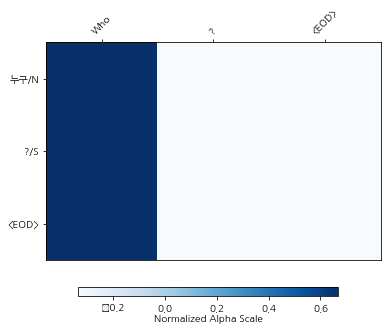

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


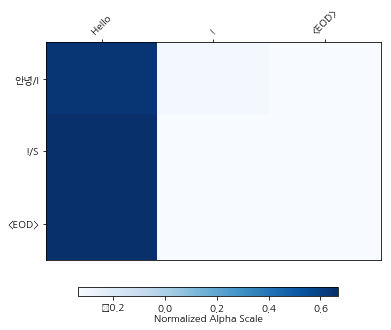

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


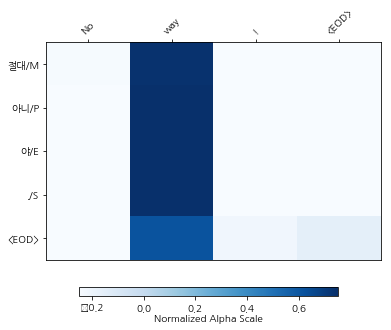

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


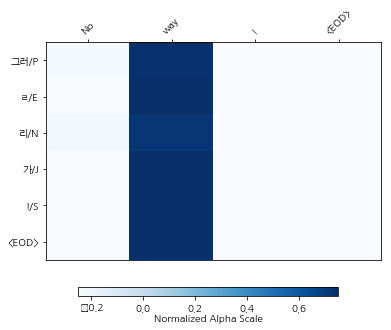

Epoch 100/200 Batch    0/227 - Loss:  0.244
[[[0.00000000e+00 0.00000000e+00 8.24821170e-33 8.54395878e-08
   2.36629732e-02 9.76336956e-01 4.02761505e-11 8.46531598e-20
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 9.23629506e-11 1.00000000e+00 2.55542985e-16
   7.48792270e-28 1.15234837e-26]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   9.57341905e-22 9.99998927e-01 1.09333132e-06 6.62371079e-20
   6.65330740e-22 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 6.01955064e-09 1.00000000e+00
   7.91326081e-20 1.43123744e-23 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 6.69034159e-35 3.50511426e-19
   1.51780046e-06 9.99998450e-01 2.80376249e-15 1.76942117e-26
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   1.25642999e-37 2.74651191e-10 1.95039511e-01 8.04960549e-01
   1.76110897e-11 1.09245230

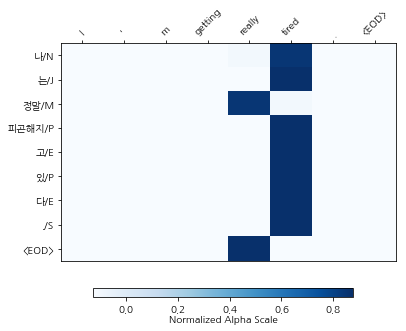

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


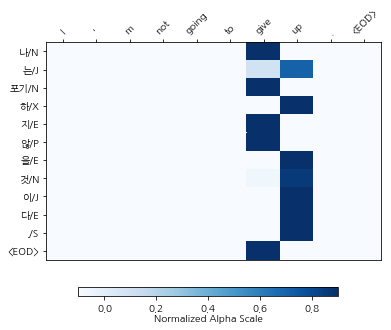

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


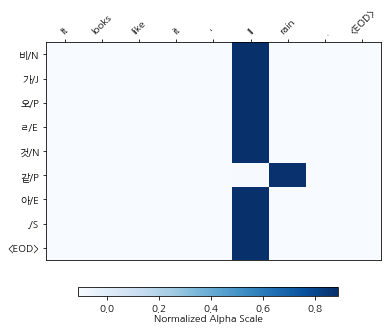

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


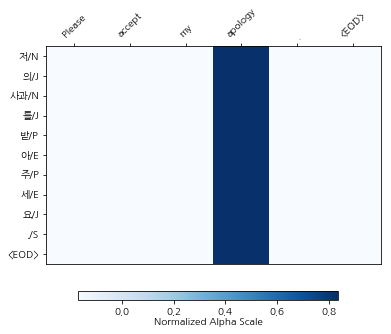

Epoch 100/200 Batch  100/227 - Loss:  0.014
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   3.88089737e-26 9.96702373e-01 3.29758506e-03 1.81053259e-22
   2.05208643e-23]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 7.74045509e-29 2.98505583e-05
   9.99970198e-01 1.01718386e-21 9.00719902e-25 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 3.78557229e-33 9.99995112e-01 4.87180887e-06
   1.21314711e-21 8.46095149e-32 7.63010738e-33 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   1.29025845e-31 3.52563320e-18 5.34721448e-06 9.99994636e-01
   3.78991338e-10 3.91812797e-12 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e

   0.00000000e+00]]]
input: I couldn ' t get the cork out of the bottle . <EOD>
gener: 병/N 에서/J 코르크/N 를/J 빼/P ㄹ/E 수/N 없/P 었어/E ./S <EOD>


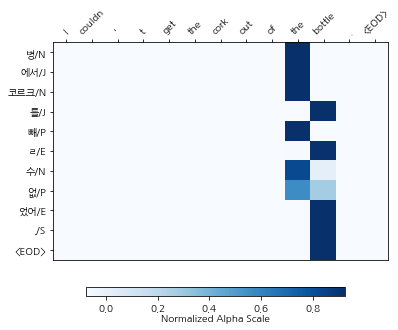

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


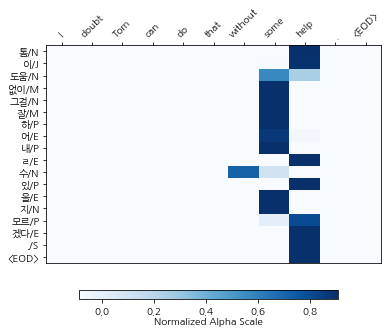

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


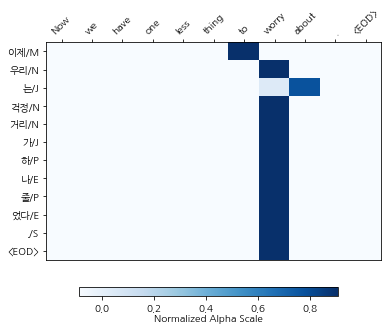

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


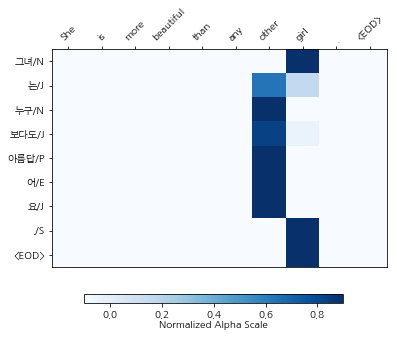

Epoch 100/200 Batch  200/227 - Loss:  0.068
Train perplexity: 1.08770
Epoch 101/200 Batch    0/227 - Loss:  0.856
Epoch 101/200 Batch  100/227 - Loss:  0.009
Epoch 101/200 Batch  200/227 - Loss:  0.006
Train perplexity: 1.09046
Epoch 102/200 Batch    0/227 - Loss:  0.396
Epoch 102/200 Batch  100/227 - Loss:  0.011
Epoch 102/200 Batch  200/227 - Loss:  0.034
Train perplexity: 1.10503
Epoch 103/200 Batch    0/227 - Loss:  0.362
Epoch 103/200 Batch  100/227 - Loss:  0.050
Epoch 103/200 Batch  200/227 - Loss:  0.077
Train perplexity: 1.17506
Epoch 104/200 Batch    0/227 - Loss:  0.417
Epoch 104/200 Batch  100/227 - Loss:  0.046
Epoch 104/200 Batch  200/227 - Loss:  0.272
Train perplexity: 1.25269
Epoch 105/200 Batch    0/227 - Loss:  0.303
Epoch 105/200 Batch  100/227 - Loss:  0.040
Epoch 105/200 Batch  200/227 - Loss:  0.084
Train perplexity: 1.22770
Epoch 106/200 Batch    0/227 - Loss:  0.451
Epoch 106/200 Batch  100/227 - Loss:  0.115
Epoch 106/200 Batch  200/227 - Loss:  0.029
Train pe

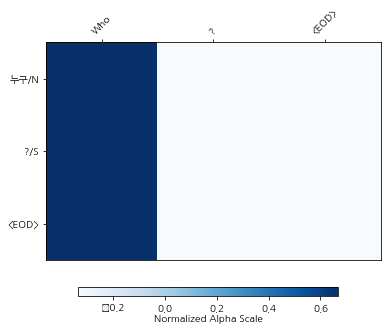

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


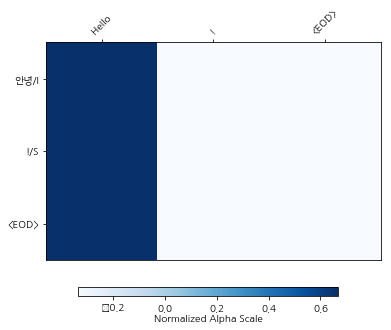

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


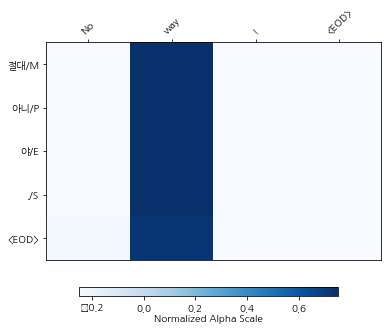

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


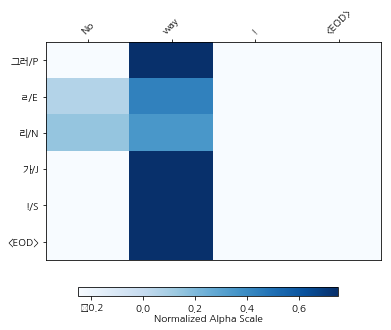

Epoch 110/200 Batch    0/227 - Loss:  0.374
[[[0.00000000e+00 0.00000000e+00 4.47702957e-34 1.73364669e-01
   4.73206758e-01 3.53428543e-01 2.65969473e-12 1.87577300e-21
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 2.35117237e-33 1.00000000e+00 2.58914175e-11
   2.74293396e-25 1.02791022e-28]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   2.92251370e-24 1.00000000e+00 1.63833690e-25 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 4.14484003e-10 1.00000000e+00
   2.69207039e-15 3.31789543e-20 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.65277863e-35
   1.49697654e-20 1.00000000e+00 1.42293116e-14 1.01086377e-26
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 6.30789437e-22 6.68795656e-06 9.99993324e-01
   1.71583355e-11 4.63912762

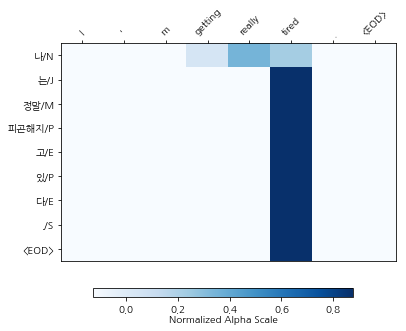

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


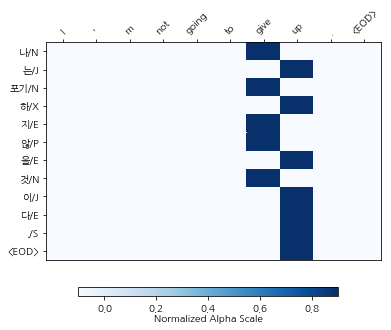

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


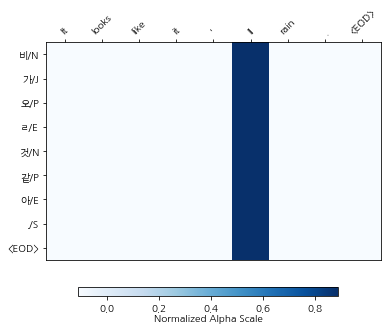

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


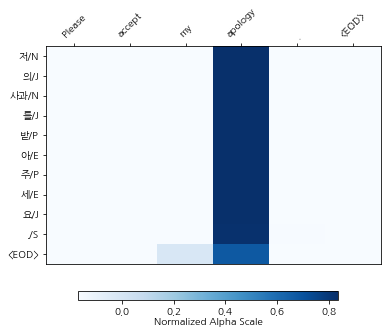

Epoch 110/200 Batch  100/227 - Loss:  0.003
[[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
   0.0000000e+00 0.0000000e+00 0.0000000e+00 7.1462894e-24 9.9999177e-01
   8.1851513e-06 1.5451027e-19 3.3400403e-20]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
   0.0000000e+00 7.6331059e-35 2.7600333e-09 1.0000000e+00 1.7891807e-20
   6.8395440e-24 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
   0.0000000e+00 2.6103487e-08 1.0000000e+00 1.6176657e-14 9.2180233e-23
   1.1813997e-27 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.5878604e-37
   1.3114772e-17 9.8387581e-01 1.6124124e-02 2.8436224e-08 2.0921544e-11
   0.0000000e+00 0.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
   0.0000000e+00 3.9839357e-35 1.5018391e-23 1.7155622e-05 9.9998283e-01
   1.1938852e-09 1.3875027e-14 4.9654025

   0.0000000e+00 0.0000000e+00 0.0000000e+00]]]
input: I couldn ' t get the cork out of the bottle . <EOD>
gener: 병/N 에서/J 코르크/N 를/J 빼/P ㄹ/E 수/N 없/P 었어/E ./S <EOD>


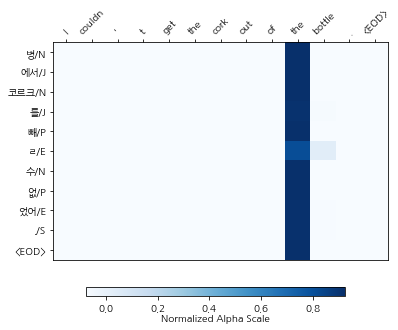

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


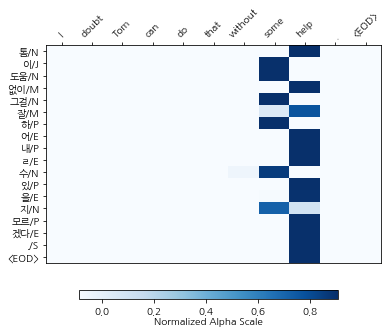

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


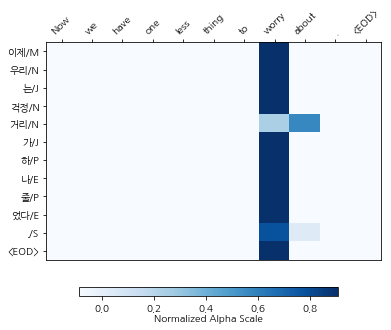

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


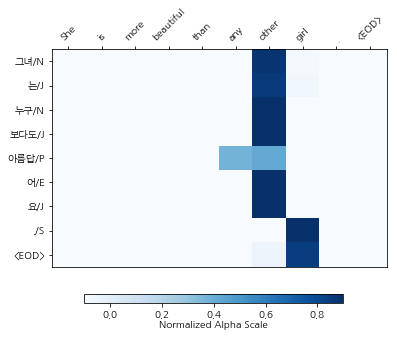

Epoch 110/200 Batch  200/227 - Loss:  0.019
Train perplexity: 1.07845
Epoch 111/200 Batch    0/227 - Loss:  0.425
Epoch 111/200 Batch  100/227 - Loss:  0.013
Epoch 111/200 Batch  200/227 - Loss:  0.005
Train perplexity: 1.07366
Epoch 112/200 Batch    0/227 - Loss:  0.443
Epoch 112/200 Batch  100/227 - Loss:  0.004
Epoch 112/200 Batch  200/227 - Loss:  0.004
Train perplexity: 1.06965
Epoch 113/200 Batch    0/227 - Loss:  0.204
Epoch 113/200 Batch  100/227 - Loss:  0.001
Epoch 113/200 Batch  200/227 - Loss:  0.003
Train perplexity: 1.06621
Epoch 114/200 Batch    0/227 - Loss:  0.428
Epoch 114/200 Batch  100/227 - Loss:  0.001
Epoch 114/200 Batch  200/227 - Loss:  0.003
Train perplexity: 1.07065
Epoch 115/200 Batch    0/227 - Loss:  0.135
Epoch 115/200 Batch  100/227 - Loss:  0.003
Epoch 115/200 Batch  200/227 - Loss:  0.001
Train perplexity: 1.07007
Epoch 116/200 Batch    0/227 - Loss:  0.266
Epoch 116/200 Batch  100/227 - Loss:  0.004
Epoch 116/200 Batch  200/227 - Loss:  0.006
Train pe

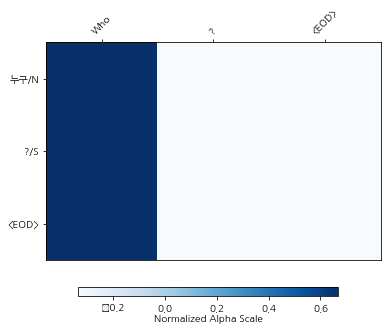

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


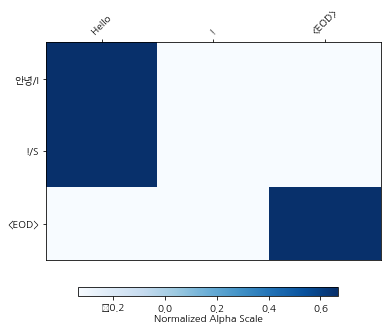

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


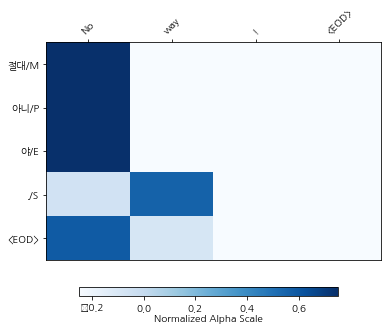

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


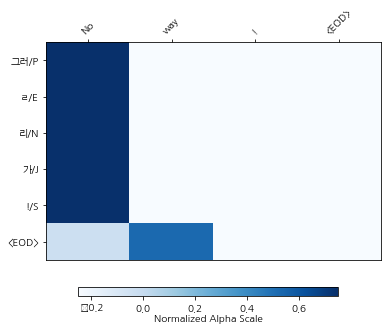

Epoch 120/200 Batch    0/227 - Loss:  0.278
[[[3.05396871e-32 2.11422330e-29 2.01209924e-10 9.99995470e-01
   4.51426422e-06 1.14412781e-08 3.07971491e-19 8.13600246e-27
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 1.74475892e-10 1.00000000e+00 5.37693350e-36
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 5.63889048e-34 3.08662503e-29 4.47754705e-23
   2.59341419e-07 9.84773159e-01 1.52265802e-02 2.98253785e-14
   4.69057804e-26 0.00000000e+00]
  [5.80167698e-33 5.12363529e-03 2.54300296e-01 7.40576088e-01
   3.35461063e-14 1.51737068e-19 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 1.75448684e-36 4.57556137e-22
   7.93451329e-12 1.00000000e+00 6.46828207e-12 1.78649380e-20
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   3.41624819e-25 9.72429116e-05 9.99902725e-01 1.24660271e-09
   2.50747957e-17 6.46742552

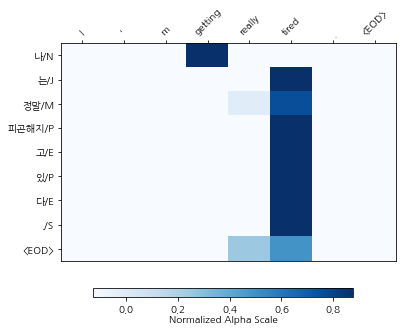

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


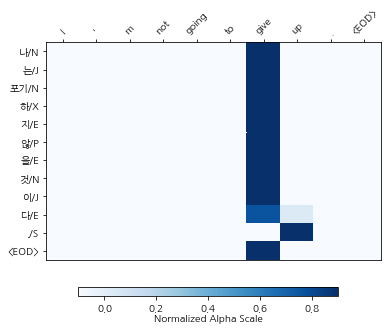

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


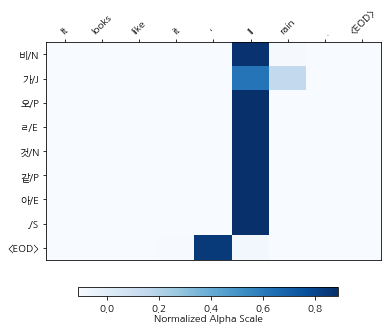

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


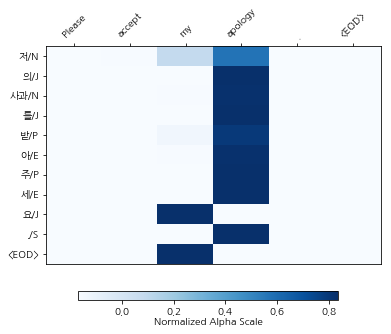

Epoch 120/200 Batch  100/227 - Loss:  0.780
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 1.00000000e+00 6.70371148e-13 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 5.20301569e-07
   9.99999523e-01 2.11583843e-28 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 9.64322567e-01 3.56775038e-02
   4.26573872e-25 2.42442599e-38 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   6.98703310e-31 9.10260907e-13 9.99976277e-01 2.37251188e-05
   1.72317282e-12 1.27769040e-25 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e

   0.00000000e+00]]]
input: I couldn ' t get the cork out of the bottle . <EOD>
gener: 병/N 에서/J 코르크/N 를/J 빼/P ㄹ/E 수/N 없/P 었어/E ./S <EOD>


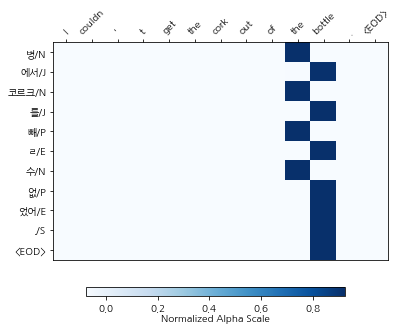

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


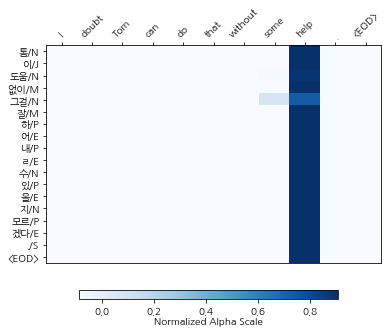

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


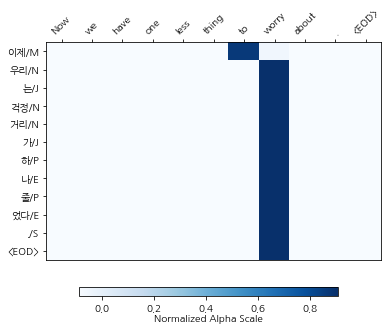

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


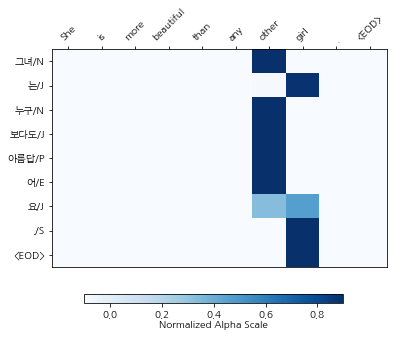

Epoch 120/200 Batch  200/227 - Loss:  0.431
Train perplexity: 1.75635
Epoch 121/200 Batch    0/227 - Loss:  0.481
Epoch 121/200 Batch  100/227 - Loss:  0.384
Epoch 121/200 Batch  200/227 - Loss:  0.358
Train perplexity: 1.35599
Epoch 122/200 Batch    0/227 - Loss:  0.443
Epoch 122/200 Batch  100/227 - Loss:  0.099
Epoch 122/200 Batch  200/227 - Loss:  0.217
Train perplexity: 1.15325
Epoch 123/200 Batch    0/227 - Loss:  0.342
Epoch 123/200 Batch  100/227 - Loss:  0.055
Epoch 123/200 Batch  200/227 - Loss:  0.174
Train perplexity: 1.10471
Epoch 124/200 Batch    0/227 - Loss:  0.351
Epoch 124/200 Batch  100/227 - Loss:  0.040
Epoch 124/200 Batch  200/227 - Loss:  0.010
Train perplexity: 1.08309
Epoch 125/200 Batch    0/227 - Loss:  0.357
Epoch 125/200 Batch  100/227 - Loss:  0.009
Epoch 125/200 Batch  200/227 - Loss:  0.011
Train perplexity: 1.07059
Epoch 126/200 Batch    0/227 - Loss:  0.256
Epoch 126/200 Batch  100/227 - Loss:  0.004
Epoch 126/200 Batch  200/227 - Loss:  0.005
Train pe

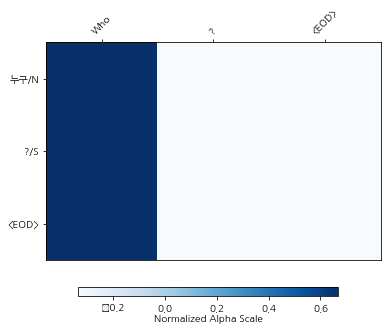

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


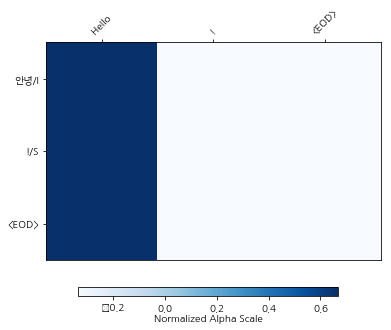

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


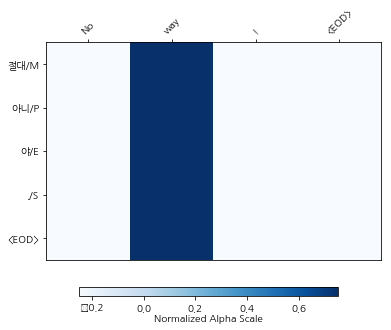

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


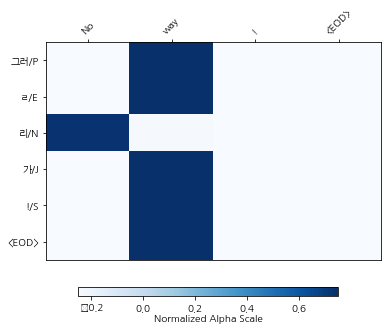

Epoch 130/200 Batch    0/227 - Loss:  0.563
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 9.74237073e-16
   1.94787374e-03 9.98052120e-01 5.65725106e-19 3.31158117e-29
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 1.67767779e-37 1.00000000e+00 1.08300668e-25
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   3.46760979e-21 9.99999404e-01 6.30961665e-07 2.51010317e-26
   1.76448854e-34 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 1.56570740e-22 1.00000000e+00
   1.10557544e-20 1.32631754e-29 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   3.61419409e-25 1.00000000e+00 2.78981278e-22 6.28797757e-35
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   4.37046214e-31 1.16287005e-07 9.95596707e-01 4.39049350e-03
   1.23442296e-05 3.80507970

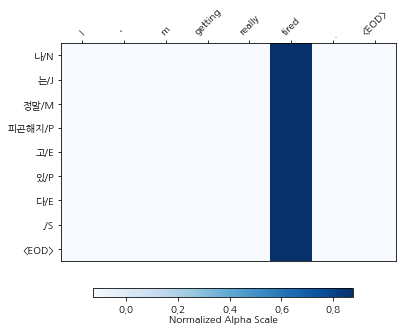

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


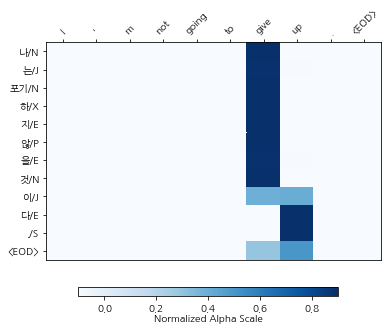

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


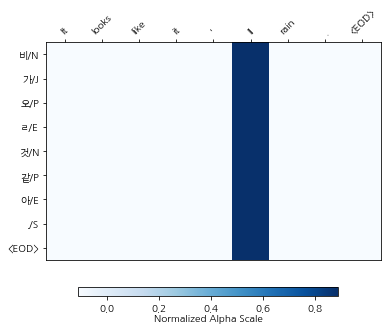

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


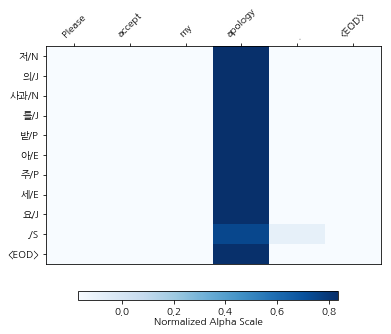

Epoch 130/200 Batch  100/227 - Loss:  0.010
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 9.99955177e-01 4.47645361e-05 2.57867758e-25
   3.14460575e-29]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 4.56038123e-08
   1.00000000e+00 2.53526922e-26 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 1.60483199e-14 1.00000000e+00
   1.38051871e-24 3.67577267e-34 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   2.18740802e-35 7.25485175e-17 6.88975334e-01 3.11024457e-01
   2.47041442e-07 1.79899464e-15 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 2.75771824e

   0.00000000e+00]]]
input: I couldn ' t get the cork out of the bottle . <EOD>
gener: 병/N 에서/J 코르크/N 를/J 빼/P ㄹ/E 수/N 없/P 었어/E ./S <EOD>


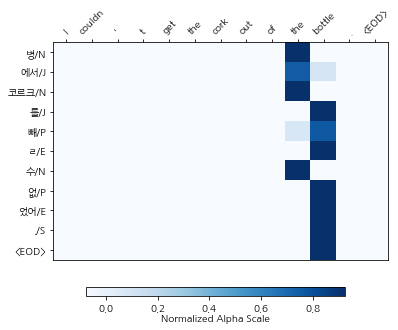

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


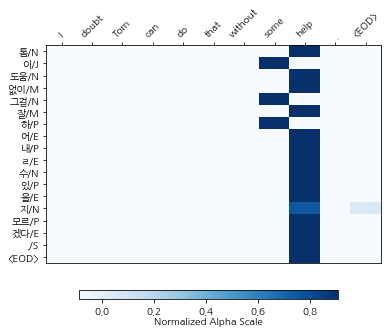

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


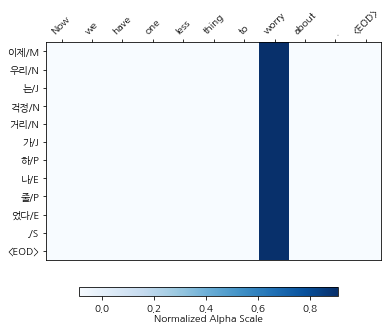

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


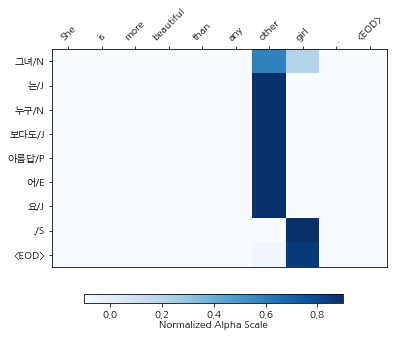

Epoch 130/200 Batch  200/227 - Loss:  0.006
Train perplexity: 1.06944
Epoch 131/200 Batch    0/227 - Loss:  0.338
Epoch 131/200 Batch  100/227 - Loss:  0.009
Epoch 131/200 Batch  200/227 - Loss:  0.052
Train perplexity: 1.07174
Epoch 132/200 Batch    0/227 - Loss:  0.383
Epoch 132/200 Batch  100/227 - Loss:  0.024
Epoch 132/200 Batch  200/227 - Loss:  0.173
Train perplexity: 1.08777
Epoch 133/200 Batch    0/227 - Loss:  0.320
Epoch 133/200 Batch  100/227 - Loss:  0.033
Epoch 133/200 Batch  200/227 - Loss:  0.018
Train perplexity: 1.08488
Epoch 134/200 Batch    0/227 - Loss:  0.235
Epoch 134/200 Batch  100/227 - Loss:  0.009
Epoch 134/200 Batch  200/227 - Loss:  0.109
Train perplexity: 1.15055
Epoch 135/200 Batch    0/227 - Loss:  1.141
Epoch 135/200 Batch  100/227 - Loss:  0.249
Epoch 135/200 Batch  200/227 - Loss:  0.201
Train perplexity: 1.30249
Epoch 136/200 Batch    0/227 - Loss:  0.842
Epoch 136/200 Batch  100/227 - Loss:  0.163
Epoch 136/200 Batch  200/227 - Loss:  0.394
Train pe

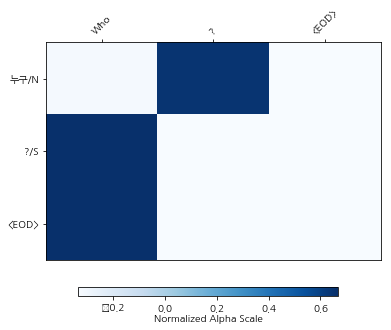

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


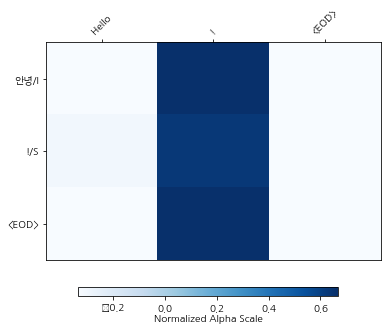

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


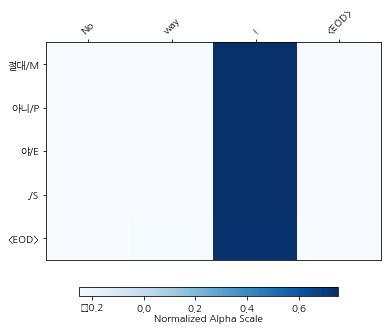

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


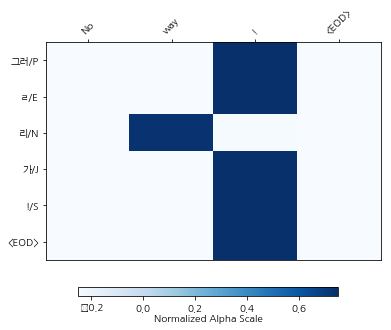

Epoch 140/200 Batch    0/227 - Loss:  0.226
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.55102289e-15
   9.99995589e-01 4.38693223e-06 1.36788382e-25 2.35959782e-34
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 5.99667315e-18 1.00000000e+00 7.46194154e-29
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.68022319e-26
   2.12333941e-16 7.97452131e-08 9.99999881e-01 5.61268703e-21
   1.74886589e-30 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 1.23140286e-20 1.00000000e+00
   4.46449026e-22 4.90203127e-29 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 7.20564486e-38
   1.50565452e-18 1.00000000e+00 6.85070085e-22 6.87847572e-32
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 3.06174178e-23 1.00000000e+00 2.11669417e-14
   7.78892701e-24 3.11686462

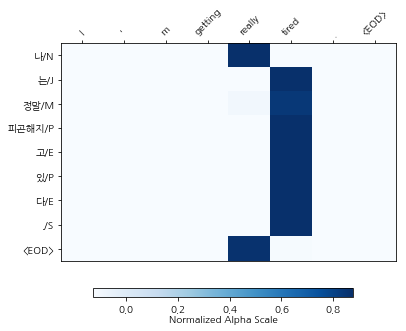

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


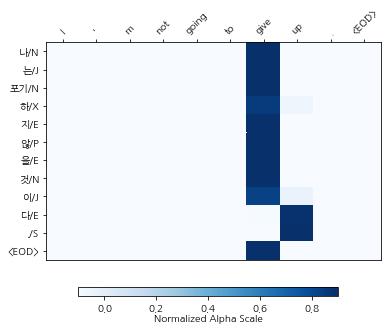

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


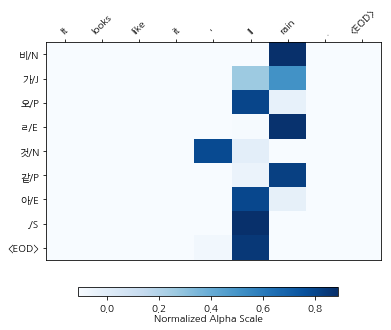

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


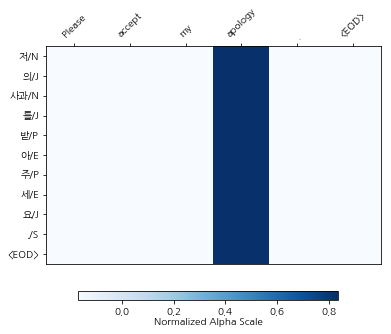

Epoch 140/200 Batch  100/227 - Loss:  0.083
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   1.16248948e-27 1.00000000e+00 5.83397886e-10 6.89650687e-30
   2.29516081e-30]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 1.64414262e-29 6.52630851e-02
   9.34736967e-01 1.36605049e-22 2.08303061e-25 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 1.39843477e-38 1.00000000e+00 9.30579988e-35
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   5.88658372e-31 1.32040743e-12 6.35014789e-04 9.99365032e-01
   4.44520983e-11 4.33958052e-14 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e

   0.00000000e+00]]]
input: I couldn ' t get the cork out of the bottle . <EOD>
gener: 병/N 에서/J 코르크/N 를/J 빼/P ㄹ/E 수/N 없/P 었어/E ./S <EOD>


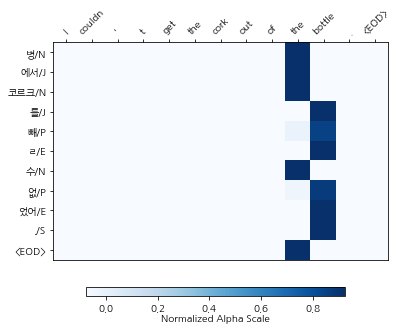

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


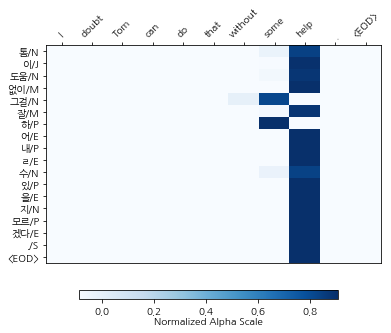

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


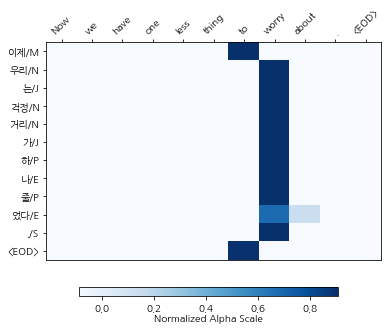

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


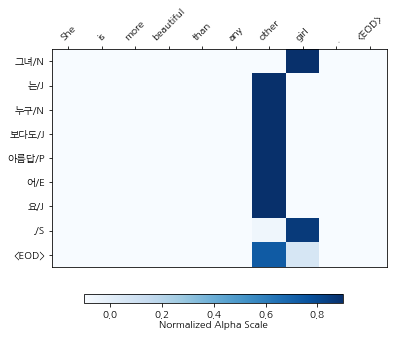

Epoch 140/200 Batch  200/227 - Loss:  0.008
Train perplexity: 1.07050
Epoch 141/200 Batch    0/227 - Loss:  0.405
Epoch 141/200 Batch  100/227 - Loss:  0.003
Epoch 141/200 Batch  200/227 - Loss:  0.009
Train perplexity: 1.06396
Epoch 142/200 Batch    0/227 - Loss:  0.224
Epoch 142/200 Batch  100/227 - Loss:  0.017
Epoch 142/200 Batch  200/227 - Loss:  0.006
Train perplexity: 1.05945
Epoch 143/200 Batch    0/227 - Loss:  0.300
Epoch 143/200 Batch  100/227 - Loss:  0.002
Epoch 143/200 Batch  200/227 - Loss:  0.005
Train perplexity: 1.05774
Epoch 144/200 Batch    0/227 - Loss:  0.222
Epoch 144/200 Batch  100/227 - Loss:  0.004
Epoch 144/200 Batch  200/227 - Loss:  0.013
Train perplexity: 1.05680
Epoch 145/200 Batch    0/227 - Loss:  0.237
Epoch 145/200 Batch  100/227 - Loss:  0.004
Epoch 145/200 Batch  200/227 - Loss:  0.005
Train perplexity: 1.06075
Epoch 146/200 Batch    0/227 - Loss:  0.203
Epoch 146/200 Batch  100/227 - Loss:  0.001
Epoch 146/200 Batch  200/227 - Loss:  0.006
Train pe

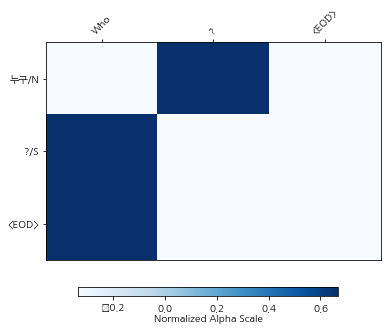

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


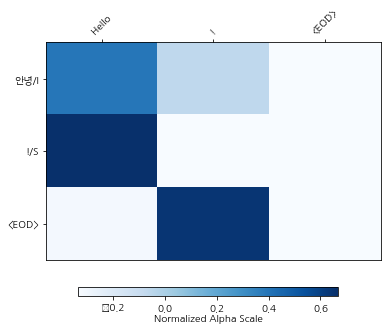

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


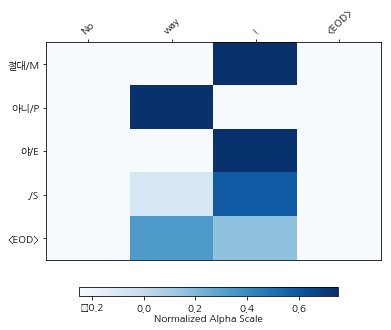

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


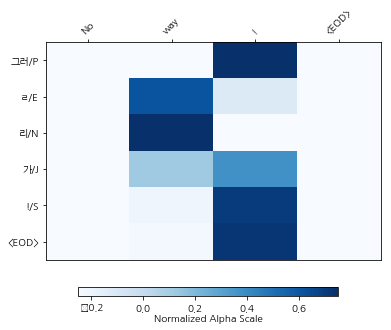

Epoch 150/200 Batch    0/227 - Loss:  0.295
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 3.36135655e-16
   1.00000000e+00 4.25653539e-08 3.62557172e-33 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 6.67562434e-33 1.00000000e+00 3.46681586e-15
   5.05136489e-32 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   4.97055808e-18 9.90431964e-01 9.56803560e-03 3.37732390e-19
   2.62682972e-29 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 3.05831602e-34 1.00000000e+00
   3.65067541e-34 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 8.05026946e-36
   5.37502477e-14 1.00000000e+00 1.60107714e-22 1.37301658e-35
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 5.32899192e-27 1.00000000e+00 1.61035540e-09
   1.34031556e-20 9.89585761

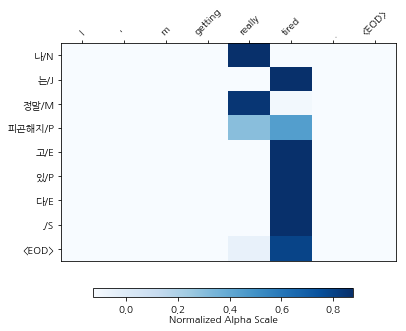

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


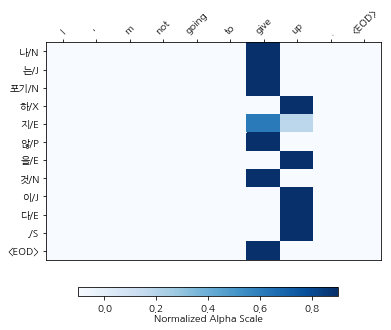

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


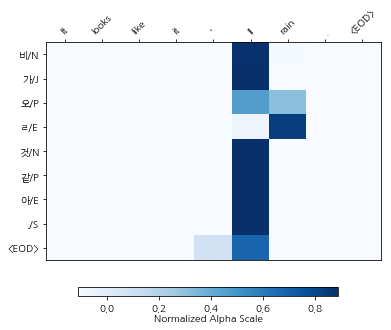

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


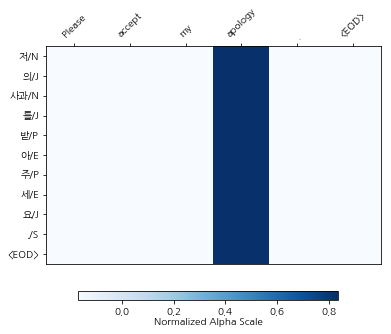

Epoch 150/200 Batch  100/227 - Loss:  0.072
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   6.97967004e-21 1.00000000e+00 4.90153747e-17 3.05610645e-30
   6.53739336e-34]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 3.61963129e-21 6.50272131e-01
   3.49727899e-01 1.81353654e-21 4.51516557e-28 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 1.59581266e-02 9.84041929e-01
   1.85466376e-09 5.08392107e-23 2.45106300e-31 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 6.00967031e-21 1.69252977e-03 9.98307467e-01
   3.34728652e-20 1.26152062e-24 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e

   0.00000000e+00]]]
input: I couldn ' t get the cork out of the bottle . <EOD>
gener: 병/N 에서/J 코르크/N 를/J 빼/P ㄹ/E 수/N 없/P 었어/E ./S <EOD>


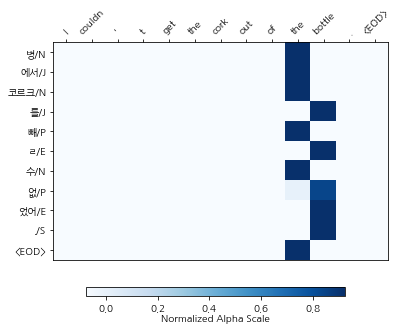

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


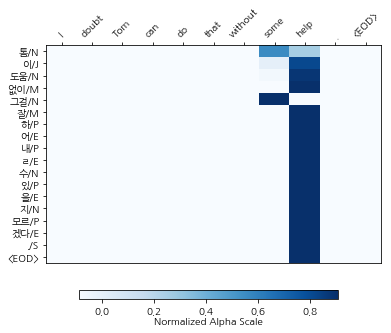

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


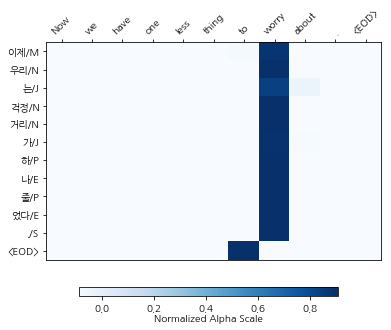

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


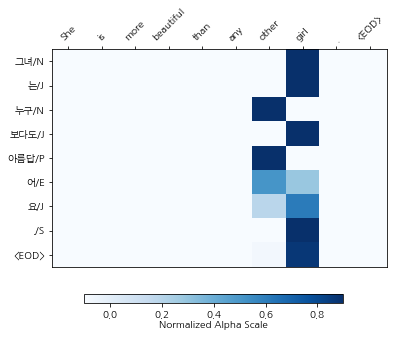

Epoch 150/200 Batch  200/227 - Loss:  0.555
Train perplexity: 1.31709
Epoch 151/200 Batch    0/227 - Loss:  0.191
Epoch 151/200 Batch  100/227 - Loss:  0.178
Epoch 151/200 Batch  200/227 - Loss:  0.124
Train perplexity: 1.29343
Epoch 152/200 Batch    0/227 - Loss:  0.229
Epoch 152/200 Batch  100/227 - Loss:  0.018
Epoch 152/200 Batch  200/227 - Loss:  0.090
Train perplexity: 1.20263
Epoch 153/200 Batch    0/227 - Loss:  0.311
Epoch 153/200 Batch  100/227 - Loss:  0.040
Epoch 153/200 Batch  200/227 - Loss:  0.010
Train perplexity: 1.15608
Epoch 154/200 Batch    0/227 - Loss:  0.250
Epoch 154/200 Batch  100/227 - Loss:  0.009
Epoch 154/200 Batch  200/227 - Loss:  0.040
Train perplexity: 1.10488
Epoch 155/200 Batch    0/227 - Loss:  0.211
Epoch 155/200 Batch  100/227 - Loss:  0.020
Epoch 155/200 Batch  200/227 - Loss:  0.103
Train perplexity: 1.09744
Epoch 156/200 Batch    0/227 - Loss:  0.493
Epoch 156/200 Batch  100/227 - Loss:  0.007
Epoch 156/200 Batch  200/227 - Loss:  0.064
Train pe

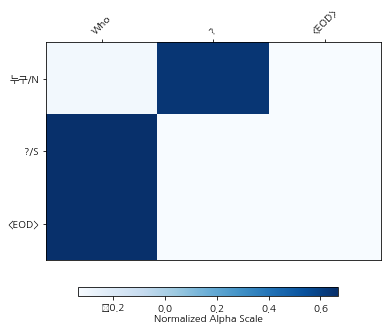

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


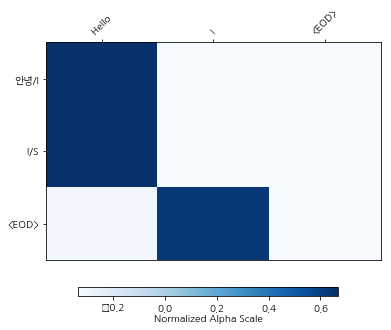

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


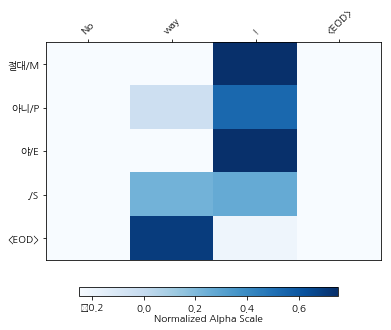

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


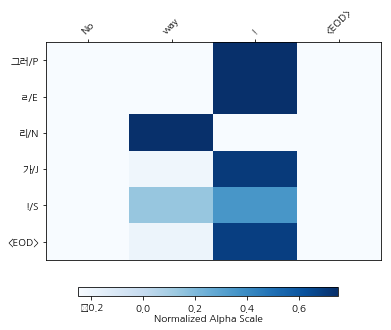

Epoch 160/200 Batch    0/227 - Loss:  0.216
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 3.65814601e-10
   9.99979854e-01 2.01673738e-05 1.60535128e-21 3.52687280e-33
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 2.22157035e-03 9.97778475e-01 6.90215782e-17
   3.19040156e-26 1.53386131e-29]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.63958413e-36
   5.12636877e-11 1.00000000e+00 2.40252263e-13 5.27758275e-21
   1.77256040e-24 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 5.71912363e-24 1.00000000e+00
   8.05108600e-24 4.58037975e-30 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 5.92959566e-24
   3.87287560e-13 1.00000000e+00 1.25113739e-10 1.19128887e-18
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   1.40906054e-28 9.98966813e-01 1.03319925e-03 3.68425819e-12
   4.86363506e-17 2.31608348

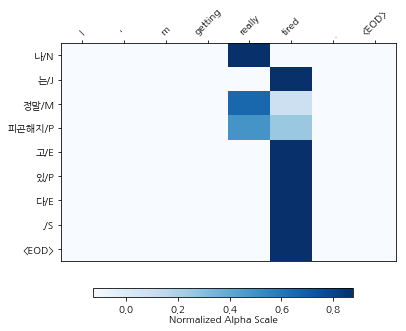

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


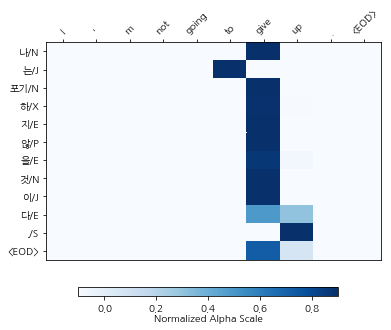

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


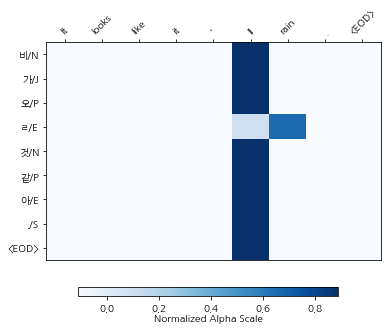

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


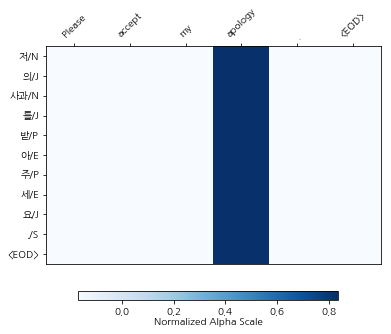

Epoch 160/200 Batch  100/227 - Loss:  0.060
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 3.22247494e-32
   1.00000497e-09 1.00000000e+00 8.45845814e-21 5.63602710e-30
   9.34426732e-32]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 6.57723466e-16 9.98937547e-01
   1.06249005e-03 1.99509698e-18 3.07892288e-26 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 2.08931441e-29 1.00000000e+00 7.11898910e-13
   5.16092723e-24 2.37263977e-28 2.38955682e-32 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 1.34754461e-15 1.11617781e-01 8.88382256e-01
   1.48412275e-13 1.10840276e-19 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 4.84939470e

   0.00000000e+00]]]
input: I couldn ' t get the cork out of the bottle . <EOD>
gener: 병/N 에서/J 코르크/N 를/J 빼/P ㄹ/E 수/N 없/P 었어/E ./S <EOD>


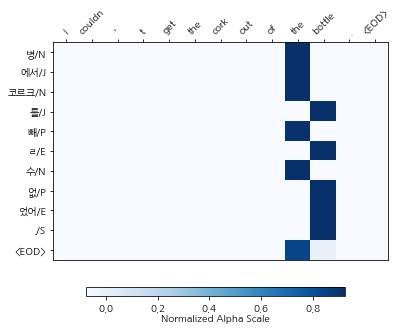

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


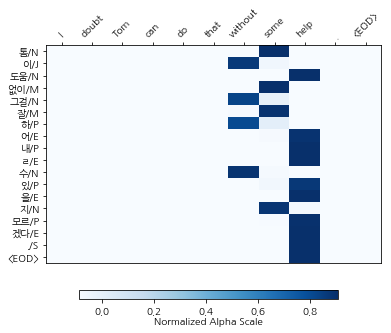

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


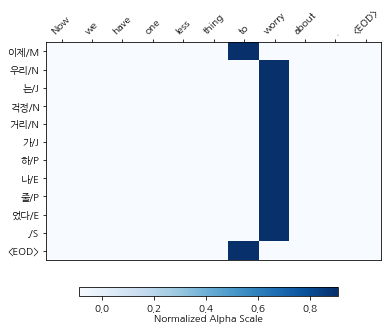

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


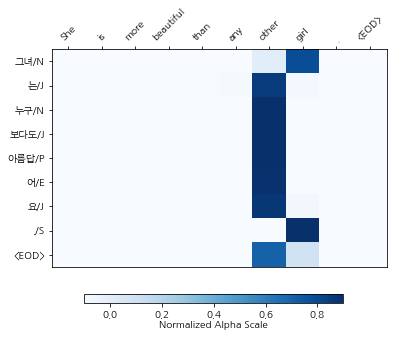

Epoch 160/200 Batch  200/227 - Loss:  0.081
Train perplexity: 1.08731
Epoch 161/200 Batch    0/227 - Loss:  0.333
Epoch 161/200 Batch  100/227 - Loss:  0.013
Epoch 161/200 Batch  200/227 - Loss:  0.027
Train perplexity: 1.08870
Epoch 162/200 Batch    0/227 - Loss:  0.231
Epoch 162/200 Batch  100/227 - Loss:  0.014
Epoch 162/200 Batch  200/227 - Loss:  0.150
Train perplexity: 1.11719
Epoch 163/200 Batch    0/227 - Loss:  0.192
Epoch 163/200 Batch  100/227 - Loss:  0.018
Epoch 163/200 Batch  200/227 - Loss:  0.187
Train perplexity: 1.18537
Epoch 164/200 Batch    0/227 - Loss:  0.777
Epoch 164/200 Batch  100/227 - Loss:  0.071
Epoch 164/200 Batch  200/227 - Loss:  0.103
Train perplexity: 1.21051
Epoch 165/200 Batch    0/227 - Loss:  0.848
Epoch 165/200 Batch  100/227 - Loss:  0.084
Epoch 165/200 Batch  200/227 - Loss:  0.034
Train perplexity: 1.14187
Epoch 166/200 Batch    0/227 - Loss:  0.438
Epoch 166/200 Batch  100/227 - Loss:  0.048
Epoch 166/200 Batch  200/227 - Loss:  0.099
Train pe

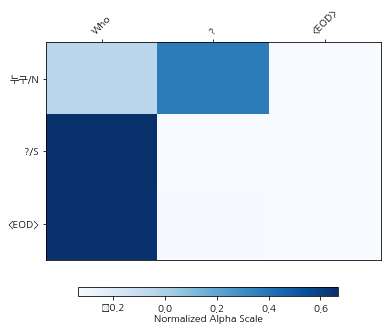

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


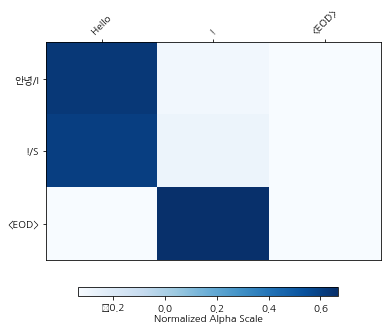

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


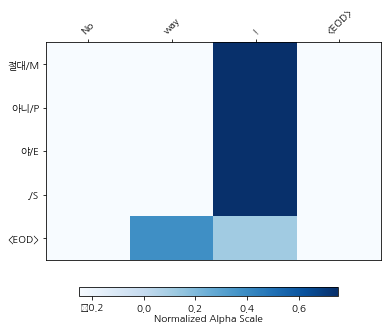

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


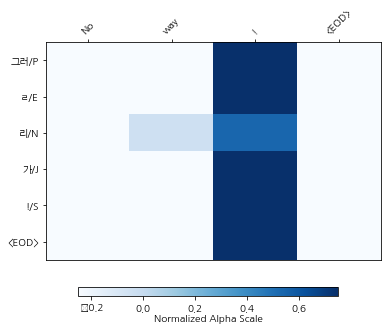

Epoch 170/200 Batch    0/227 - Loss:  0.353
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 4.59391965e-13
   1.00000000e+00 5.06640320e-11 2.96314306e-22 2.40614966e-32
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 2.68280522e-21 1.00000000e+00 2.59162744e-22
   1.29097596e-36 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   3.04676856e-24 1.00000000e+00 9.59438082e-14 3.78663145e-25
   1.86020626e-34 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 1.44816506e-36 1.00000000e+00
   2.25223654e-23 2.00207390e-37 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 6.83124307e-34
   2.05752001e-13 1.00000000e+00 1.32339976e-24 8.14055756e-38
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 3.66799581e-13 1.00000000e+00 6.35501152e-10
   9.60951951e-19 1.31089947

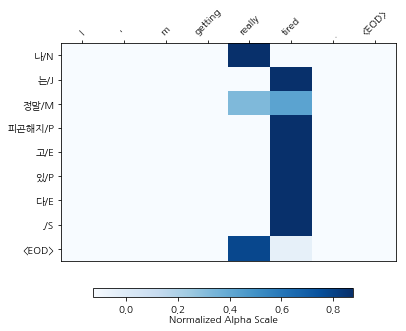

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


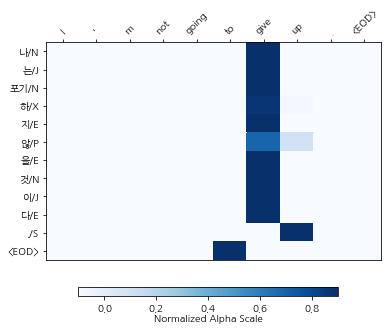

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


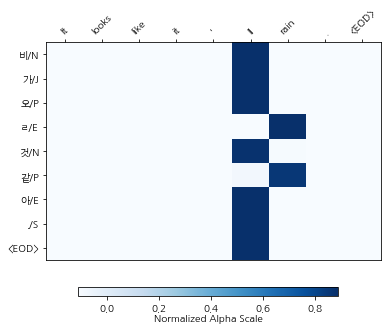

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


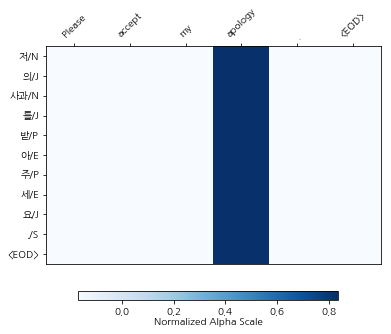

Epoch 170/200 Batch  100/227 - Loss:  0.007
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   1.45186357e-16 1.00000000e+00 5.41119504e-13 7.95532715e-21
   2.31817176e-29]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 8.81874232e-23 9.99995947e-01
   4.09512904e-06 1.39910626e-16 3.54446206e-26 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 2.04650791e-19 1.00000000e+00
   4.68251913e-12 1.42783294e-14 5.11544897e-26 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 5.27797314e-18 9.97729003e-01 2.27096328e-03
   5.20272410e-13 1.26367580e-21 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20058474e

   0.00000000e+00]]]
input: I couldn ' t get the cork out of the bottle . <EOD>
gener: 병/N 에서/J 코르크/N 를/J 빼/P ㄹ/E 수/N 없/P 었어/E ./S <EOD>


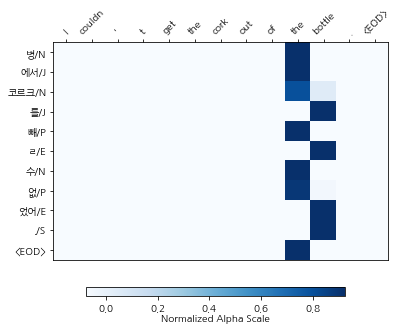

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


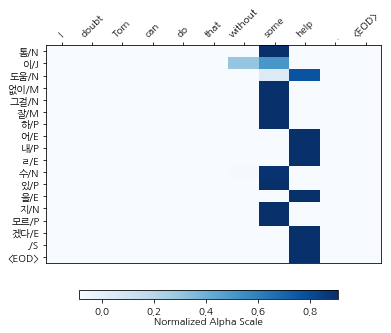

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


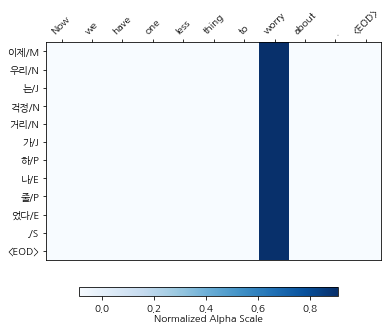

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


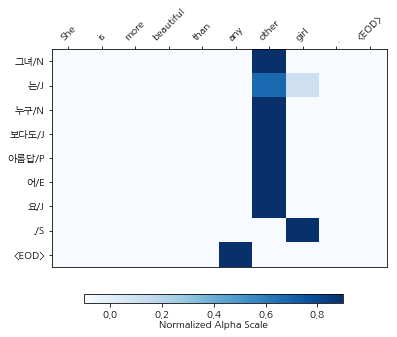

Epoch 170/200 Batch  200/227 - Loss:  0.006
Train perplexity: 1.06792
Epoch 171/200 Batch    0/227 - Loss:  0.240
Epoch 171/200 Batch  100/227 - Loss:  0.002
Epoch 171/200 Batch  200/227 - Loss:  0.005
Train perplexity: 1.06876
Epoch 172/200 Batch    0/227 - Loss:  0.257
Epoch 172/200 Batch  100/227 - Loss:  0.024
Epoch 172/200 Batch  200/227 - Loss:  0.003
Train perplexity: 1.06813
Epoch 173/200 Batch    0/227 - Loss:  0.302
Epoch 173/200 Batch  100/227 - Loss:  0.036
Epoch 173/200 Batch  200/227 - Loss:  0.002
Train perplexity: 1.07132
Epoch 174/200 Batch    0/227 - Loss:  0.236
Epoch 174/200 Batch  100/227 - Loss:  0.086
Epoch 174/200 Batch  200/227 - Loss:  0.012
Train perplexity: 1.08258
Epoch 175/200 Batch    0/227 - Loss:  0.303
Epoch 175/200 Batch  100/227 - Loss:  0.089
Epoch 175/200 Batch  200/227 - Loss:  0.016
Train perplexity: 1.11837
Epoch 176/200 Batch    0/227 - Loss:  0.215
Epoch 176/200 Batch  100/227 - Loss:  0.156
Epoch 176/200 Batch  200/227 - Loss:  0.169
Train pe

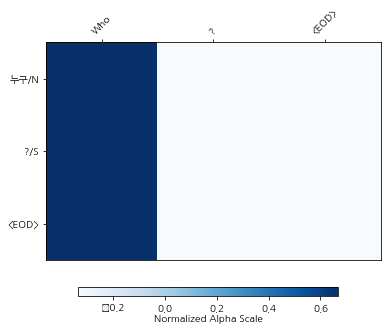

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


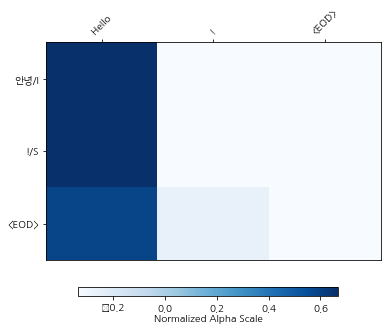

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


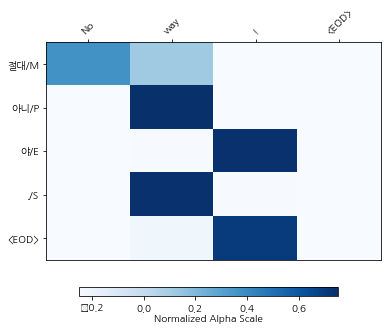

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


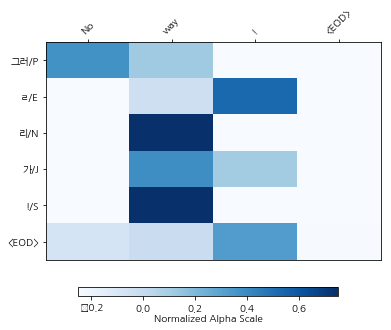

Epoch 180/200 Batch    0/227 - Loss:  0.267
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 3.08613557e-09
   9.99997854e-01 2.15152863e-06 1.28839691e-11 9.55790977e-20
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   7.99139271e-38 1.00000000e+00 1.69510699e-08 5.13302213e-11
   1.59620174e-18 2.86490516e-24]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.41768891e-23
   9.42226563e-09 1.00000000e+00 4.09011797e-10 1.38267334e-18
   4.95495206e-30 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 8.04383598e-18 1.00000000e+00
   2.52010767e-14 1.17522736e-21 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 3.21461805e-24
   7.59687873e-06 9.99992371e-01 4.36586964e-12 2.92456890e-22
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   6.98648113e-24 3.32199215e-06 9.99996662e-01 2.23889768e-10
   5.28312025e-15 1.21967327

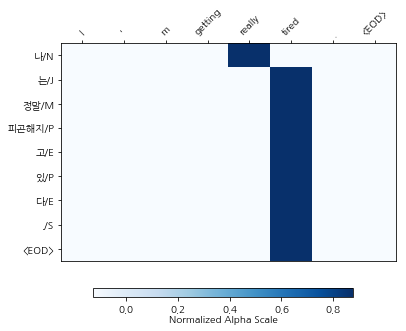

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


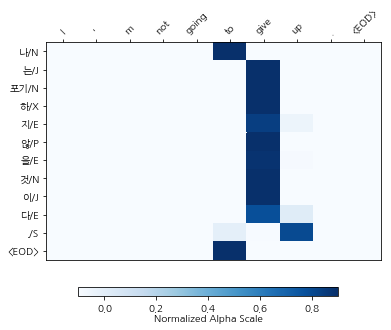

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


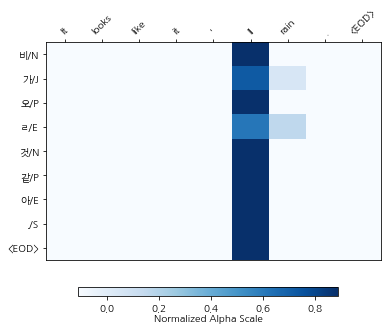

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


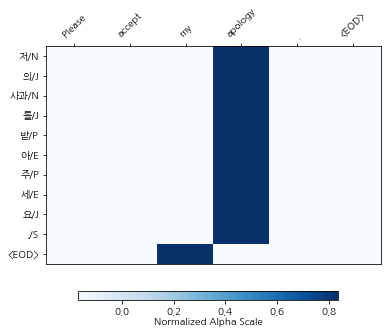

Epoch 180/200 Batch  100/227 - Loss:  0.007
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 4.57216075e-36
   7.86688936e-10 1.00000000e+00 2.69349464e-14 1.72815788e-19
   4.17172334e-23]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 5.43840066e-38 7.47419921e-12
   1.00000000e+00 3.12337995e-08 3.40688722e-16 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 3.43428284e-27 1.00000000e+00 2.48407267e-10
   5.23085832e-15 1.30939589e-22 4.36750976e-31 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 4.42306837e-27 3.37663005e-06 9.99996662e-01
   2.53675797e-13 8.97770966e-22 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 1.25569806e

   0.00000000e+00]]]
input: I couldn ' t get the cork out of the bottle . <EOD>
gener: 병/N 에서/J 코르크/N 를/J 빼/P ㄹ/E 수/N 없/P 었어/E ./S <EOD>


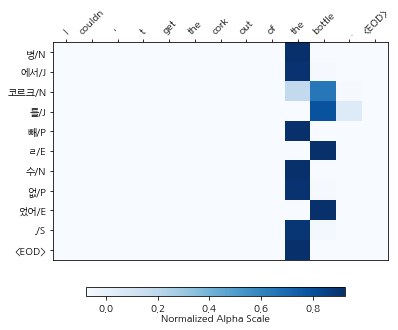

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


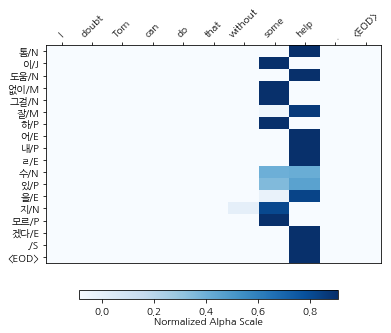

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


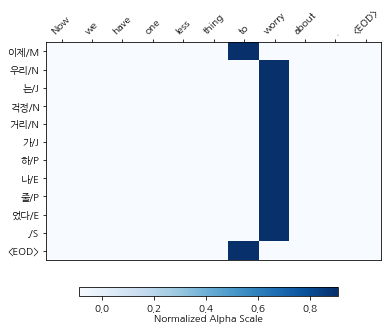

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


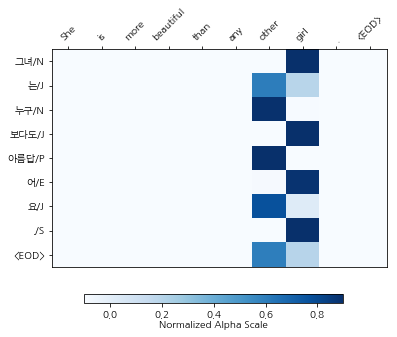

Epoch 180/200 Batch  200/227 - Loss:  0.015
Train perplexity: 1.11429
Epoch 181/200 Batch    0/227 - Loss:  0.370
Epoch 181/200 Batch  100/227 - Loss:  0.025
Epoch 181/200 Batch  200/227 - Loss:  0.076
Train perplexity: 1.10785
Epoch 182/200 Batch    0/227 - Loss:  0.273
Epoch 182/200 Batch  100/227 - Loss:  0.011
Epoch 182/200 Batch  200/227 - Loss:  0.009
Train perplexity: 1.07605
Epoch 183/200 Batch    0/227 - Loss:  0.267
Epoch 183/200 Batch  100/227 - Loss:  0.002
Epoch 183/200 Batch  200/227 - Loss:  0.004
Train perplexity: 1.06391
Epoch 184/200 Batch    0/227 - Loss:  0.246
Epoch 184/200 Batch  100/227 - Loss:  0.012
Epoch 184/200 Batch  200/227 - Loss:  0.002
Train perplexity: 1.06333
Epoch 185/200 Batch    0/227 - Loss:  0.247
Epoch 185/200 Batch  100/227 - Loss:  0.004
Epoch 185/200 Batch  200/227 - Loss:  0.003
Train perplexity: 1.06507
Epoch 186/200 Batch    0/227 - Loss:  0.231
Epoch 186/200 Batch  100/227 - Loss:  0.004
Epoch 186/200 Batch  200/227 - Loss:  0.007
Train pe

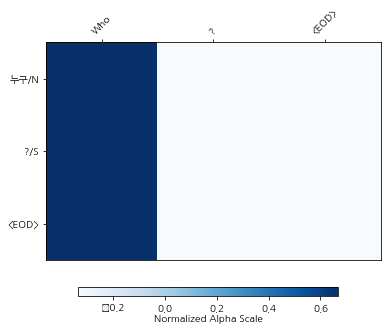

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


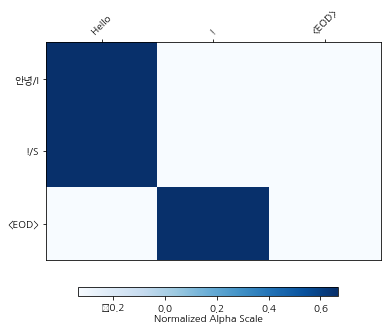

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


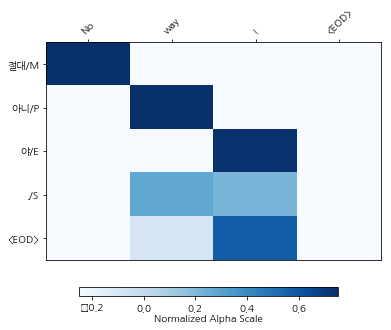

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


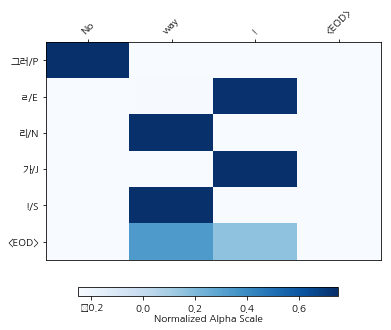

Epoch 190/200 Batch    0/227 - Loss:  0.201
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 3.58774843e-10
   9.99993563e-01 6.48455307e-06 3.23406741e-17 1.15261847e-25
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 1.00000000e+00 9.11651366e-10 5.16275952e-16
   3.82941137e-25 9.69004004e-31]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.83174924e-21
   6.16364071e-09 1.00000000e+00 5.72931529e-11 2.37803425e-18
   1.01027450e-25 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 1.08577904e-16 1.00000000e+00
   1.76455177e-17 2.59968187e-26 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 5.69610169e-38 1.45855914e-11
   3.22879493e-01 6.77120566e-01 2.32554644e-13 7.84629203e-23
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   6.00355019e-23 2.43565402e-04 9.99756396e-01 2.81096302e-09
   1.37778474e-15 2.78618886

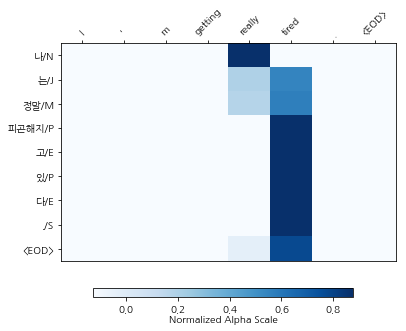

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


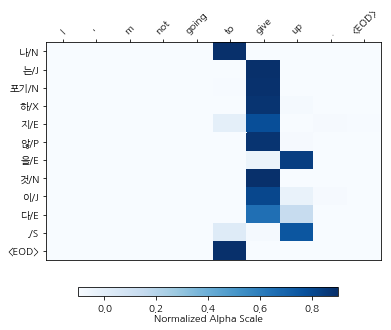

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


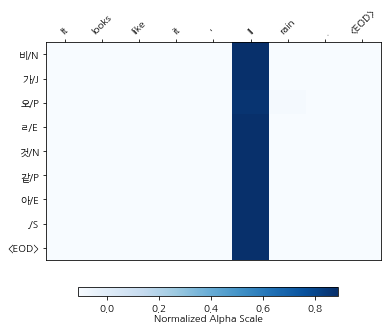

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


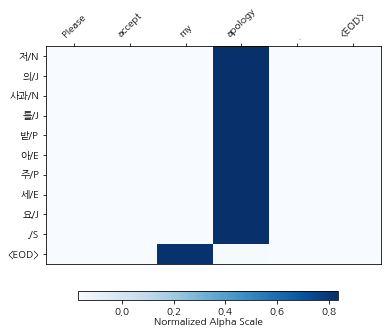

Epoch 190/200 Batch  100/227 - Loss:  0.071
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 6.97048231e-38
   1.58094579e-11 1.00000000e+00 3.93795337e-18 1.07118991e-25
   9.22643823e-29]
  [0.00000000e+00 0.00000000e+00 3.59174702e-37 0.00000000e+00
   0.00000000e+00 0.00000000e+00 4.30125356e-21 3.32323625e-03
   9.96676803e-01 1.75062839e-10 3.52845974e-16 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 2.88470252e-22 1.00000000e+00 3.45284497e-19
   7.33825223e-27 2.09761328e-35 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 4.31188450e-38 1.01502000e-35
   8.35417682e-34 8.74624605e-14 9.54509806e-03 9.90454853e-01
   1.14195120e-09 1.89006674e-13 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 3.97694614e

   0.00000000e+00]]]
input: I couldn ' t get the cork out of the bottle . <EOD>
gener: 병/N 에서/J 코르크/N 를/J 빼/P ㄹ/E 수/N 없/P 었어/E ./S <EOD>


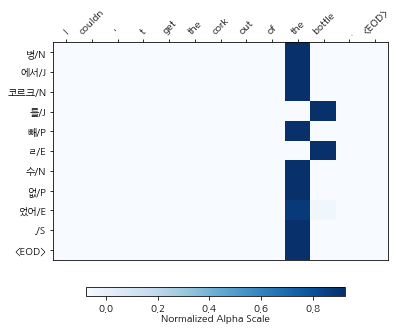

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


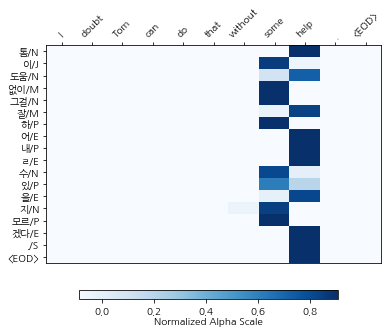

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


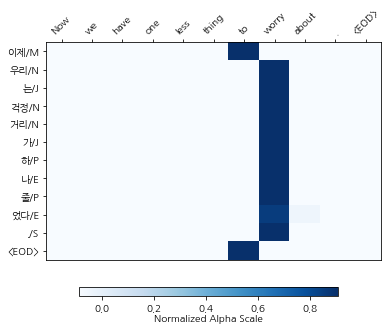

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


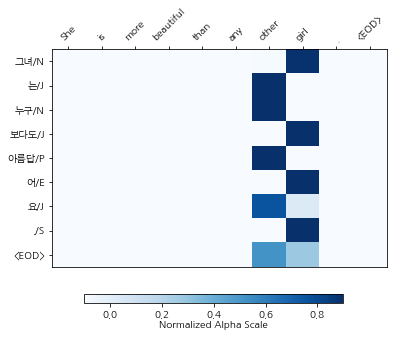

Epoch 190/200 Batch  200/227 - Loss:  0.002
Train perplexity: 1.05659
Epoch 191/200 Batch    0/227 - Loss:  0.209
Epoch 191/200 Batch  100/227 - Loss:  0.015
Epoch 191/200 Batch  200/227 - Loss:  0.001
Train perplexity: 1.05551
Epoch 192/200 Batch    0/227 - Loss:  0.164
Epoch 192/200 Batch  100/227 - Loss:  0.001
Epoch 192/200 Batch  200/227 - Loss:  0.021
Train perplexity: 1.06250
Epoch 193/200 Batch    0/227 - Loss:  0.193
Epoch 193/200 Batch  100/227 - Loss:  0.003
Epoch 193/200 Batch  200/227 - Loss:  0.810
Train perplexity: 1.09492
Epoch 194/200 Batch    0/227 - Loss:  0.268
Epoch 194/200 Batch  100/227 - Loss:  0.067
Epoch 194/200 Batch  200/227 - Loss:  0.749
Train perplexity: 1.29652
Epoch 195/200 Batch    0/227 - Loss:  0.105
Epoch 195/200 Batch  100/227 - Loss:  0.112
Epoch 195/200 Batch  200/227 - Loss:  0.561
Train perplexity: 1.55071
Epoch 196/200 Batch    0/227 - Loss:  0.596
Epoch 196/200 Batch  100/227 - Loss:  0.050
Epoch 196/200 Batch  200/227 - Loss:  0.102
Train pe

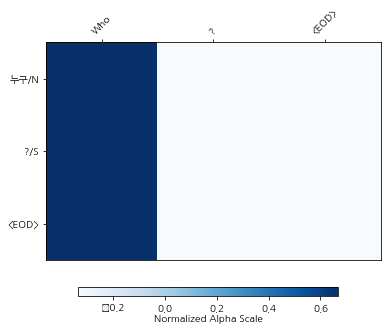

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


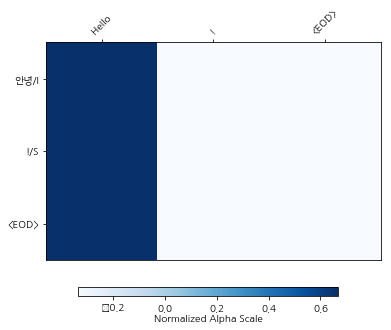

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


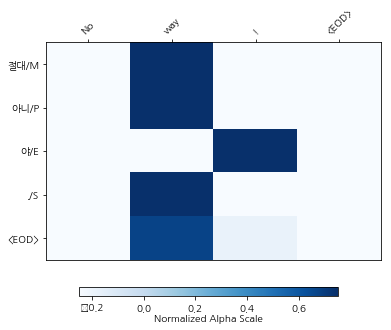

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


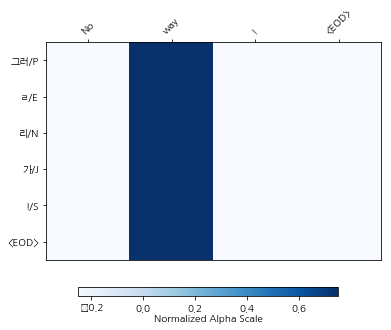

Epoch 200/200 Batch    0/227 - Loss:  0.512
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 7.28323904e-26
   2.79511022e-03 9.97204840e-01 2.34518058e-08 6.83508181e-19
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 7.61842173e-26 1.00000000e+00 1.94649066e-13
   3.82592553e-23 4.80360495e-37]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   6.35951543e-16 1.00000000e+00 1.57358854e-13 1.14421967e-24
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 1.30475901e-29 1.00000000e+00
   2.74021343e-26 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.75467626e-34
   4.22398539e-18 1.00000000e+00 1.30409161e-15 1.36557955e-26
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 1.57638225e-13 1.00000000e+00 3.91084463e-13
   5.20216755e-21 5.92924400

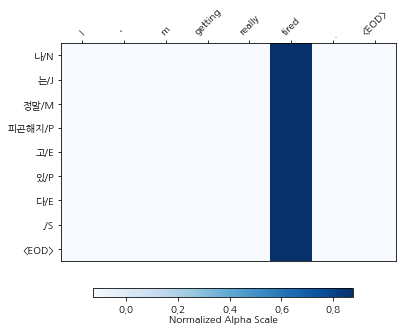

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


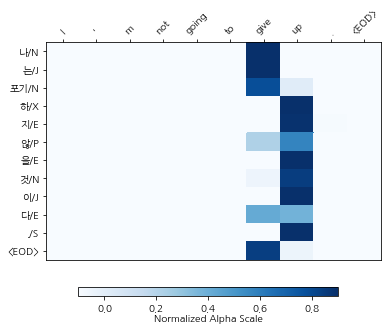

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


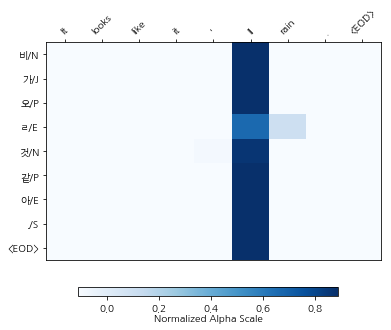

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


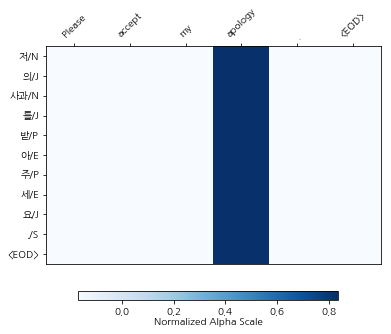

Epoch 200/200 Batch  100/227 - Loss:  0.090
[[[0.00000000e+00 1.24128552e-36 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 7.00673956e-35
   1.84989744e-03 9.98150110e-01 2.64449412e-14 2.19878193e-18
   7.72732028e-26]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 7.96971718e-19 2.49554705e-05
   9.99975085e-01 5.66548815e-13 3.73925308e-26 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 2.59952593e-09 1.00000000e+00
   6.45867244e-25 2.96210326e-37 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 3.06137575e-33 3.84018585e-06 9.99996185e-01
   1.27528457e-12 6.54967938e-25 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 4.71747689e-37 5.98943825e

   0.00000000e+00]]]
input: I couldn ' t get the cork out of the bottle . <EOD>
gener: 병/N 에서/J 코르크/N 를/J 빼/P ㄹ/E 수/N 없/P 었어/E ./S <EOD>


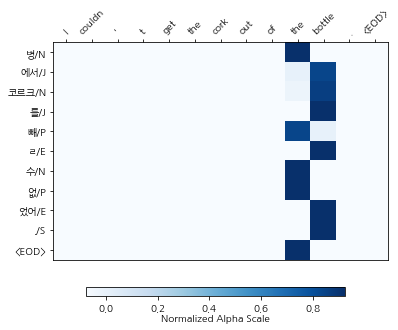

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


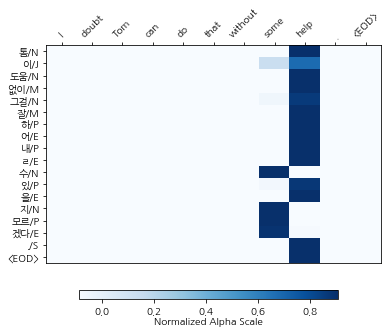

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


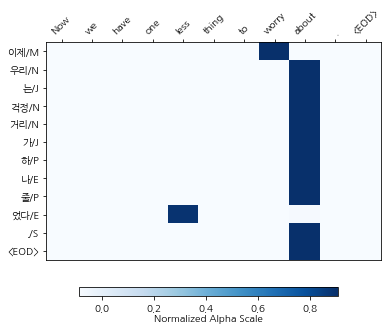

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


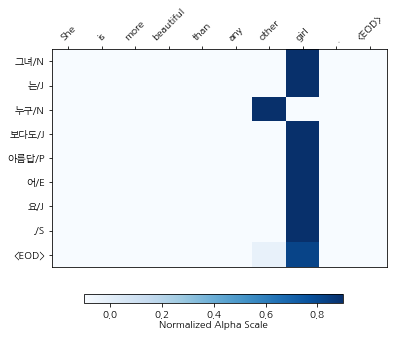

Epoch 200/200 Batch  200/227 - Loss:  0.008
Train perplexity: 1.06958
Run Time : 2978.7861907482147 seconds


In [21]:
import time
import numpy as np
from __future__ import unicode_literals

display_step = 100
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC'

test_step = 10

_att = []

with tf.Session (graph = tf_graph, config=config) as sess:
    start_time = time.time()
    sess.run(tf.global_variables_initializer())
    
    for epoch_i in range(0, epochs+1):
        _tcosts = []
        for batch_i, (sources_batch, targets_batch, source_lengths, target_lengths) in enumerate(get_batches(source_sent_ids,
                                                                                                            source_sent_ids,
                                                                                                            batch_size,
                                                                                                             voca_e_to_int[PAD],
                                                                                                             voca_e_to_int[PAD]
                                                                                                            )):
            if batch_i % display_step == 0 and epoch_i%test_step==0:
                _, loss, attention = sess.run([train_op, cost, training_decoder_state.alignment_history.stack()], feed_dict={input_data: sources_batch,
                                                     targets: targets_batch,
                                                     lr: learning_rate,
                                                     target_sequence_length: target_lengths,
                                                     source_sequence_length: source_lengths})
                _att = attention
                print(_att)
                

                for ans_i in range(batch_size):
                    ans = targets_batch[ans_i]
                    _ans = ""
                    for v in ans:
                        if v == voca_e_to_int[EOD]:

                            _ans += int_to_voca_e[v]
                            break
                        else:

                            _ans += int_to_voca_e[v]+" "



                    org = sources_batch[ans_i]
                    _org = ""
                    for v in org:
                        if v == voca_e_to_int[EOD]:
                            _org += int_to_voca_e[v]
                            break
                        else:
                            _org += int_to_voca_e[v]+" "

                    print("input: {}".format(_org))
                    print("gener: {}".format(_ans))
                    my_plot(attention[:target_lengths[ans_i], ans_i, :source_lengths[ans_i]], _org.split(), _ans.split())
                #print(_att)                
                
            else:
                _, loss = sess.run([train_op, cost], feed_dict={input_data: sources_batch,
                                                     targets: targets_batch,
                                                     lr: learning_rate,
                                                     target_sequence_length: target_lengths,
                                                     source_sequence_length: source_lengths})
            

            
            _tcosts.append(loss)
            
            #print(batch_i, loss)
            
            if batch_i % display_step == 0:
                print('Epoch {:>3}/{} Batch {:>4}/{} - Loss: {:>6.3f}'.format(epoch_i, 
                                                                              epochs,
                                                                              batch_i,
                                                                              len(source_sent_ids)//batch_size,
                                                                              loss))  
                '''
                if epoch_i%test_step == 0:
                    for attn_i in range(batch_size):
                        ans = targets_batch[attn_i]

                        _ans = ""
                        for v in ans:
                            if v == voca_k_to_int[EOD]:
                                _ans += int_to_voca_k[v]
                                break
                            else:
                                _ans += int_to_voca_k[v]+" "



                        org = sources_batch[attn_i]
                        _org = ""
                        for v in org:
                            if v == voca_e_to_int[EOD]:
                                _org += int_to_voca_e[v]
                                break
                            else:
                                _org += int_to_voca_e[v]+" "

                        #print(attention[:source_lengths[attn_i], attn_i, :source_lengths[attn_i]])                        
                        #plot_attention(attention[:source_lengths[attn_i], attn_i, :source_lengths[attn_i]], _org.split(), _ans.split())
                        
                        my_plot(attention[:, attn_i, :source_lengths[attn_i]], _org.split(), [GO]+_ans.split())
                        #read_plot_alignment_matrices(_org.split(), _ans.split(), attention[:source_lengths[attn_i],attn_i, :source_lengths[attn_i]])
                '''
            #print(sources_batch)
            
        
        print('Train perplexity: {:>6.5f}'.format(np.exp(np.mean(_tcosts))))
        '''
        if epoch_i%test_step == 0:
            (sources_batch, targets_batch, source_lengths, target_lengths) in enumerate(get_batches(source_sent_ids,
                                                                                                   target_sent_ids,
                                                                                                   batch_size,
                                                                                                   voca_e_to_int[PAD],
                                                                                                   voca_k_to_int[PAD]))
            answer_logits, attention = sess.run([inference_logits, training_decoder_state.alignment_history.stack()], feed_dict={input_data: sources_batch,
                                                       targets: targets_batch,
                                                        target_sequence_length: target_lengths,source_sequence_length: source_lengths})
        
            for ans_i in range(len(answer_logits)):
                ans = np.transpose(answer_logits[ans_i]).tolist()[0]
                _ans = ""
                for v in ans:
                    if v == voca_k_to_int[EOD]:
                        
                        _ans += int_to_voca_k[v]
                        break
                    else:
                        
                        _ans += int_to_voca_k[v]+" "
                        
                
                
                org = sources_batch[ans_i]
                _org = ""
                for v in org:
                    if v == voca_e_to_int[EOD]:
                        _org += int_to_voca_e[v]
                        break
                    else:
                        _org += int_to_voca_e[v]+" "
                        
                print("input: {}".format(_org))
                print("gener: {}".format(_ans))
                my_plot(attention[:, ans_i, :source_lengths[ans_i]], _org.split(), [GO]+_ans.split())
        
        #break
        '''
    run_time = time.time() - start_time
    print('Run Time : %s seconds' %(run_time))

In [30]:
print(batch_size)
print(len(_att), len(_att[0,:,:]), len(_att[:, 0, :]), len(_att[:, :, 0]))
print(_att)


16
7 16 7 7
[[[0.33343878 0.3332922  0.33326903 0.         0.         0.        ]
  [0.33336186 0.3333806  0.33325756 0.         0.         0.        ]
  [0.25013822 0.24988881 0.24990554 0.25006747 0.         0.        ]
  [0.25013688 0.25013605 0.24981354 0.24991348 0.         0.        ]
  [0.33331153 0.3333761  0.33331236 0.         0.         0.        ]
  [0.16672722 0.16668999 0.16670161 0.16653372 0.16670887 0.16663855]
  [0.20021477 0.20005678 0.19991048 0.19987218 0.19994581 0.        ]
  [0.3334753  0.33319205 0.33333272 0.         0.         0.        ]
  [0.24986565 0.25009865 0.2499379  0.25009772 0.         0.        ]
  [0.33329123 0.33342668 0.33328205 0.         0.         0.        ]
  [0.3333457  0.3333357  0.33331862 0.         0.         0.        ]
  [0.2497865  0.25017434 0.24996549 0.25007364 0.         0.        ]
  [0.24990506 0.25016525 0.24994993 0.24997978 0.         0.        ]
  [0.16675521 0.16662984 0.1665238  0.16659883 0.16684759 0.16664474]
  [0.249

In [138]:
pair_kor[0:8]

[['누구/N', '?/S', '<EOD>'],
 ['안녕/I', '!/S', '<EOD>'],
 ['절대/M', '아니/P', '야/E', './S', '<EOD>'],
 ['그러/P', 'ㄹ/E', '리/N', '가/J', '!/S', '<EOD>'],
 ['안녕/I', '!/S', '<EOD>'],
 ['슬프/P', '어/E', './S', '<EOD>'],
 ['나/N', '도/J', './S', '<EOD>'],
 ['완벽/N', '하/X', '어/E', '!/S', '<EOD>']]

In [139]:
pair_eng[0:8]

[['Who', '?', '<EOD>'],
 ['Hello', '!', '<EOD>'],
 ['No', 'way', '!', '<EOD>'],
 ['No', 'way', '!', '<EOD>'],
 ['Goodbye', '!', '<EOD>'],
 ['I', "'", 'm', 'sad', '.', '<EOD>'],
 ['Me', ',', 'too', '.', '<EOD>'],
 ['Perfect', '!', '<EOD>']]

In [31]:
print(_att[:, 0, :])

[[0.33343878 0.3332922  0.33326903 0.         0.         0.        ]
 [0.333445   0.3333258  0.33322918 0.         0.         0.        ]
 [0.33347863 0.3333419  0.33317944 0.         0.         0.        ]
 [0.3335072  0.33335373 0.33313906 0.         0.         0.        ]
 [0.3335482  0.33336085 0.33309102 0.         0.         0.        ]
 [0.3335482  0.33336085 0.33309102 0.         0.         0.        ]
 [0.3335482  0.33336085 0.33309102 0.         0.         0.        ]]


In [140]:
print(attention)

[[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 6.6657353e-30
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.6688689e-36
   0.0000000e+00 0.0000000e+00]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.3934238e-08
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.000